In [1]:
%matplotlib inline
import os
import logging
from typing import *
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s ', level=logging.DEBUG)
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import loompy
import cytograph as cg
from scipy import sparse
import scipy.cluster.hierarchy as hc
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches
from matplotlib import cm
import numpy_groupies.aggregate_numpy as npg
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from sklearn.decomposition import PCA
from sklearn.neighbors import BallTree, NearestNeighbors, kneighbors_graph
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.manifold import TSNE
from matplotlib.collections import LineCollection
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from polo import optimal_leaf_ordering
from scipy.stats import norm, t
import scipy.io as io
import pickle
from numba.decorators import jit, autojit
from scipy.io import mmread
import random
import string
import community
from statsmodels import robust
import pandas as pd
from sklearn.svm import SVR
%config InlineBackend.figure_format = 'retina'

In [313]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    print(ds.ca.keys())
#    print(ds.ca.NCells[ds.ca.ClusterName=="OPC"])
#    print(ds.ca.Tissue_OB[ds.ca.ClusterName=="OPC"])

['Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'CellID', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'ClassProbability_Satellite-glia', 'ClassProbability_

In [317]:
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    print(sorted(ds.ra.Gene[np.argsort(-ds["enrichment"][:, ds.ca.ClusterName=="OBNBL1"].T[0])][:100]))


['1700023F06Rik', '2610528A11Rik', '3300002P13Rik', '6430548M08Rik', 'A230065H16Rik', 'Abi3bp', 'Adcy8', 'Ankrd34c', 'Ap1s3', 'Atp6ap1l', 'Barhl2', 'C1ql1', 'Cacng5', 'Cacng6', 'Cacng7', 'Calb2', 'Cbln1', 'Cbln2', 'Cbln4', 'Cdhr1', 'Coro6', 'Crim1', 'Deptor', 'Dkkl1', 'Doc2g', 'Eomes', 'Fam196a', 'Fst', 'Fstl4', 'Fstl5', 'Gabra3', 'Gdf11', 'Ghrh', 'Gm2694', 'Gm27199', 'Grm1', 'Hpse', 'Igfbp5', 'Inadl', 'Iqsec3', 'Kcnk15', 'Klhdc8a', 'Lhfp', 'Lhfpl3', 'Lmtk2', 'Lrrc55', 'Mdga1', 'Mitf', 'Ms4a15', 'Myh8', 'Nbeal2', 'Ndnf', 'Ndst4', 'Nmb', 'Npr1', 'Nptx2', 'Nrip3', 'Ntng1', 'Nxph4', 'Otop2', 'Pkib', 'Plcxd2', 'Ppm1j', 'Prune2', 'Rab26', 'Rab37', 'Rab3b', 'Rapgef3', 'Rasa4', 'Rasgrp1', 'Rassf4', 'Raver2', 'Rbp7', 'Rd3l', 'Reln', 'Rspo3', 'Ryr1', 'Samd3', 'Scube1', 'Sema3a', 'Shisa3', 'Slc17a7', 'Slc6a7', 'Spp1', 'Syt7', 'Syt9', 'Tbx21', 'Tcf15', 'Tfap2c', 'Tmem108', 'Tmem163', 'Tmem40', 'Tnfaip8', 'Tshz2', 'Tubb6', 'Txnrd3', 'Ush1g', 'Vdr', 'Xrcc3', 'Zfp804a']


### Supplementary Figure 1

In [ ]:
"Nmu","Scgn","Grp","Penk","Cckar","Tac1","Dmkn", "Nos1","Gal","Cck","Vip","Npy","Cartpt","Ngb"

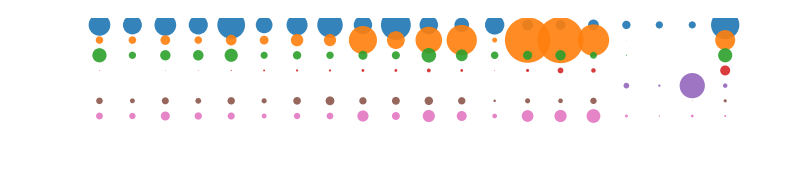

In [21]:
d = {}
flist = [
 'L1_Olfactory.loom',
 'L1_Cortex1.loom',
 'L1_Cortex2.loom',
 'L1_Cortex3.loom',
 'L1_Hippocampus.loom',
 'L1_StriatumDorsal.loom',
 'L1_StriatumVentral.loom',
 'L1_Amygdala.loom',
 'L1_Thalamus.loom',
 'L1_Hypothalamus.loom',
 'L1_MidbrainDorsal.loom',
 'L1_MidbrainVentral.loom',
 'L1_Cerebellum.loom',
 'L1_Pons.loom',
 'L1_Medulla.loom',
 'L1_SpinalCord.loom',
 'L1_DRG.loom',
 'L1_Sympathetic.loom',
 'L1_Enteric.loom'
]
for f in flist:
    if f.startswith("L1") and f.endswith(".loom") and not f.endswith(".agg.loom"):
        with loompy.connect("/Users/sten/build_20171205/" + f) as ds:
            for cls in ['Neurons', 'Oligos', 'Astrocytes', 'Ependymal', 'PeripheralGlia', 'Immune', 'Vascular']:
                if cls not in d:
                    d[cls] = []
                d[cls].append((ds.ca.Class == cls).sum())
fig = plt.figure(figsize=(19/3,1))
ax = fig.add_subplot(111)
ax.axis("off")
ix = 7
legend = [0, 100, 250, 500, 2500, 5000,10000, 20000]
for key, vals in d.items():
    vals.append(legend[ix])
    plt.scatter(np.arange(20), np.zeros(20) + ix, s=np.array(vals)/100, alpha=0.9, lw=0)
    ix -= 1
plt.savefig("classes.pdf", bbox_inches='tight')

In [54]:
vals = np.zeros(20)
for k,v in d.items():
    vals = vals + v
np.array(d["PeripheralGlia"]/vals)[-4:-1]

array([ 0.29046088,  0.08736559,  0.91527858])

### Figure 1

In [7]:
annf = "/Users/stelin/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Submission_180323/Table S3.xlsx"
anns = pd.read_excel(annf)
anns.fillna("", inplace=True)

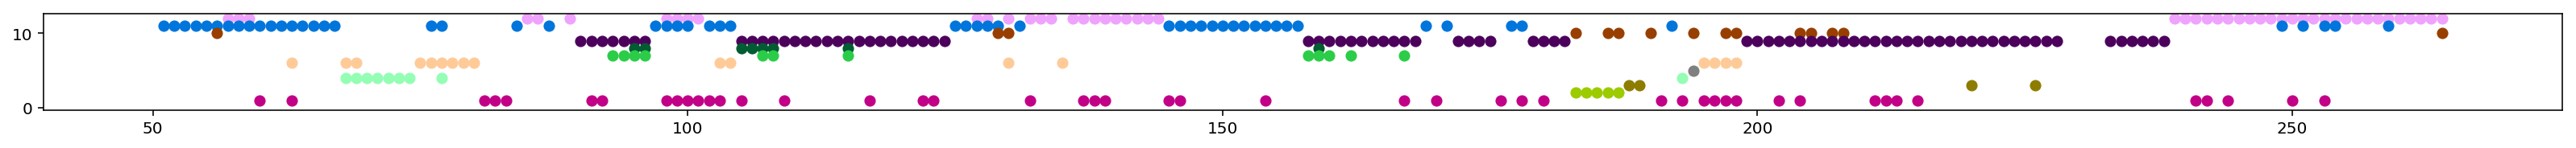

In [9]:
nts=anns["Neurotransmitter"].values[np.argsort(-anns["Dendrogram order"].values)]
plt.figure(figsize=(28, 1.1))
labels=["VGLUT1", "VGLUT2", "VGLUT3", "GABA", "GLYT1", "GLYT2", "Acetylcholine", "Adrenaline", "Noradrenaline", "Dopamine", "Serotonin", "Nitric oxide"]
colors = cg.colorize(np.arange(12))
for ix, nt in enumerate(labels):
    selection = np.array([(nt in x) for x in nts.astype(str)])
    plt.scatter(np.arange(265)[selection],np.zeros(selection.sum()) + (12 - ix), c=colors[ix],lw=0,s=50)
    plt.savefig("nts.pdf")

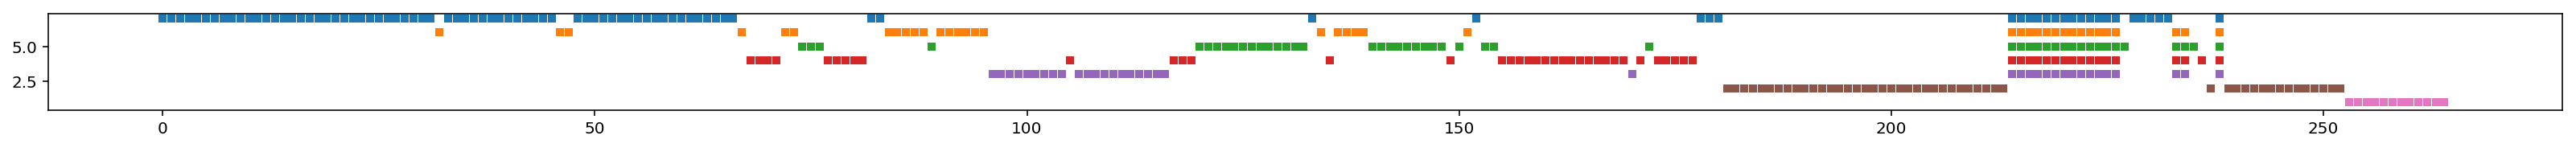

In [82]:
regspec=celltypes_summary["Developmental_compartment"].values[np.argsort(-celltypes_summary["LeafOrder"])]
plt.figure(figsize=(28, 1.1))
regions=["Telencephalon", "Diencephalon", "Mesencephalon", "Rhombencephalon", "Spinal cord", "Neural crest", "Mesoderm"]
colors = plt.cm.tab10.colors #cg.colorize(np.arange(21))[-7:]
mapping = {
    "CNS": ["Telencephalon", "Diencephalon", "Mesencephalon", "Rhombencephalon", "Spinal cord"],
    "Diencephalon": ["Diencephalon"],
    "Telencephalon": ["Telencephalon"],
    "Mesencephalon": ["Mesencephalon"],
    "Rhombencephalon": ["Rhombencephalon"],
    "Spinal cord": ["Spinal cord"],
    "Neural crest": ["Neural crest"]
}
for ix, r in enumerate(regions):
    selection = np.array([(r in x) for x in regspec.astype(str)])
    if r in ["Telencephalon", "Diencephalon", "Mesencephalon", "Rhombencephalon", "Spinal cord"]:
        selection = selection | np.array([("CNS" in x) for x in regspec.astype(str)])
    if r in ["Diencephalon", "Mesencephalon", "Rhombencephalon", "Spinal cord"]:
        selection = selection | np.array([("Diencephalon,Mesencephalon,Rhombencephalon,Spinal cord" in x) for x in regspec.astype(str)])
    plt.scatter(np.arange(265)[selection],np.zeros(selection.sum()) + (7 - ix), c=colors[ix],lw=0,s=25, marker='s')
    plt.savefig("regions.pdf")


In [280]:
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

def plot_gene_specificity(rank, taxon):
    with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
        data = ds.layers["trinaries"][:, :]
        n_in = (ds.ca[f"TaxonomyRank{rank}"] == taxon).sum()
        n_out = (ds.ca[f"TaxonomyRank{rank}"] != taxon).sum()
        nnz_in = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] == taxon] > 0.99, axis=1)
        nnz_out = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] != taxon] > 0.99, axis=1)
        nz_in = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] == taxon] <= 0.01, axis=1)
        nz_out = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] != taxon] <= 0.01, axis=1)
        pvals = np.zeros(data.shape[0])
        for ix in range(data.shape[0]):
            table = np.array([[nnz_in[ix], nnz_out[ix]], [nz_in[ix], nz_out[ix]]])
            (_, pvals[ix]) = fisher_exact(table, alternative="greater")
        (_, qvals, _, _) = multipletests(pvals, 0.05, method="fdr_bh")
        selected = (qvals < 0.2) & (nnz_in > 0.7 * n_in) & (nnz_out < 0.1 * n_out)
        plt.scatter(nnz_in + np.random.normal(size=ds.shape[0], scale=0.1), nnz_out + np.random.normal(size=ds.shape[0], scale=0.1), c=cg.colorize(
selected), s=5,marker='.', alpha=0.5)
        for g in list(np.sort(ds.ra.Gene[selected])):
            print(g)
#        print(selected.sum())
#        print(ds.ra.Gene[selected][np.isin(ds.ra.Gene[selected], list(cg.TFs))])

1700047M11Rik
4931406P16Rik
Abhd4
Abl1
Acsl1
Acss2
Adamts4
Adi1
Ado
Ago3
Ankrd13a
Arhgef10
Bcas1
Car14
Cd82
Cdk19
Chn2
Cln8
Cmtm5
Cpm
Creb3l2
Creb5
Ctsk
Ddit4
Ddr1
Dip2a
Dnm2
Dock10
E130308A19Rik
Ell2
Elovl1
Elovl7
Entpd5
Epb41l2
Ephb1
Fa2h
Fam102a
Fam57a
Fbxo8
Fgfr2
Frmd4b
Frmd8
Gab1
Gal3st1
Gamt
Gjc2
Gjc3
Gm15440
Gpr37
Gramd3
Grb14
Hip1r
Hipk2
Ick
Il1rap
Inppl1
Ipo13
Itgb8
Kcnj10
Lap3
Lcorl
Lims2
Llgl1
Lzts2
Mag
Map6d1
Micall1
Mog
Mon2
Mpp5
Mtf1
Myo6
Myrf
Nipa1
Nipal4
Nkx6-2
Npc1
Olig1
Olig2
Otud7b
Phc1
Phldb1
Phlpp1
Plat
Plcl1
Plekhg1
Pllp
Plxnb3
Polr3e
Ppp1r16b
Ppp2r3a
Prr18
Pycr2
Rab31
Rab33a
Rab7b
Rcbtb1
Reep3
Rffl
Rhog
Rnpepl1
Rock1
Rtkn
S1pr5
Scrg1
Sept2
Serinc5
Slain1
Smad7
Sox10
Sox8
Specc1
Spg20
St6galnac3
Strn
Stxbp3
Tbc1d14
Tjap1
Tm7sf3
Tmem125
Tmem63a
Tmem88b
Tmem98
Tns3
Tprn
Trf
Trim59
Trp53bp2
Ttyh2
Txndc16
Ugt8a
Unc5b
Usp16
Wscd1
Zdhhc9


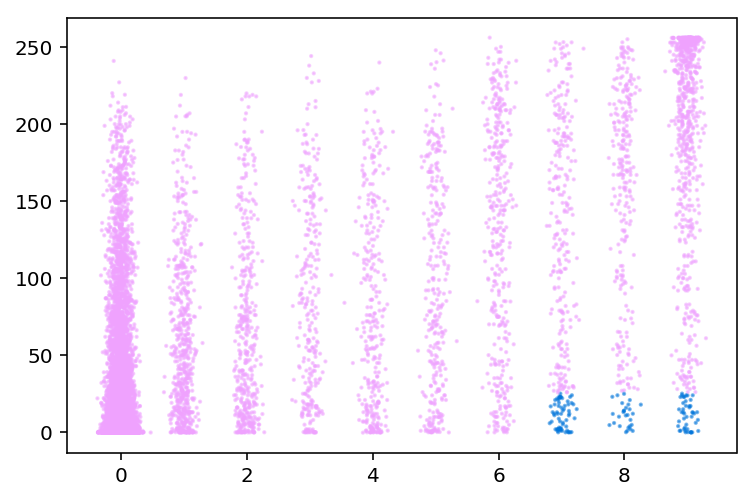

In [290]:
plot_gene_specificity(4, "Oligodendrocytes")

In [ ]:
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

def plot_gene_specificity_(rank, taxon):
    with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
        data = ds.layers["trinaries"][:, :]
        n_in = (ds.ca[f"TaxonomyRank{rank}"] == taxon).sum()
        n_out = (ds.ca[f"TaxonomyRank{rank}"] != taxon).sum()
        nnz_in = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] == taxon] > 0.99, axis=1)
        nnz_out = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] != taxon] > 0.99, axis=1)
        nz_in = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] == taxon] <= 0.01, axis=1)
        nz_out = np.count_nonzero(data[:, ds.ca[f"TaxonomyRank{rank}"] != taxon] <= 0.01, axis=1)
        pvals = np.zeros(data.shape[0])
        for ix in range(data.shape[0]):
            table = np.array([[nnz_in[ix], nnz_out[ix]], [nz_in[ix], nz_out[ix]]])
            (_, pvals[ix]) = fisher_exact(table, alternative="greater")
        (_, qvals, _, _) = multipletests(pvals, 0.05, method="fdr_bh")
        selected = (qvals < 0.2) & (nnz_in > 0.7 * n_in) & (nnz_out < 0.1 * n_out)
        plt.scatter(nnz_in + np.random.normal(size=ds.shape[0], scale=0.1), nnz_out + np.random.normal(size=ds.shape[0], scale=0.1), c=cg.colorize(
selected), s=5,marker='.', alpha=0.5)
        for g in list(np.sort(ds.ra.Gene[selected])):
            print(g)

In [330]:
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    gix = (ds.ra.Gene == "Helt")
    for ix in range(ds.shape[1]):
        if ds["trinaries"][gix, ix] > 0.95:
            print(ds.ca.ClusterName[ix])

In [61]:
spec = {
    "Age": "first",
    "Class": "mode",
    "Subclass": "mode",
    "ClusterID": "first",
    "ClusterName": "first",
    "Tissue": "tally"
}
with loompy.connect("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Datasets_comparisons/cortex_allgenes.agg2.loom") as ds:
    ds.ca.Clusters = LabelEncoder().fit_transform(ds.ca.Subclass)
    cg.Aggregator(f=[0.2, 0.05]).aggregate(ds, "/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Datasets_comparisons/cortex_allgenes.agg2.loom", agg_spec=spec)
     print(np.unique(ds.ca.ClusterName))

['(none)' 'Astro1' 'Astro2' 'CA1Pyr1' 'CA1Pyr2' 'CA1PyrInt' 'CA2Pyr2'
 'Choroid' 'ClauPyr' 'Epend' 'Int1' 'Int10' 'Int11' 'Int12' 'Int13' 'Int14'
 'Int15' 'Int16' 'Int2' 'Int3' 'Int4' 'Int5' 'Int6' 'Int7' 'Int8' 'Int9'
 'Mgl1' 'Mgl2' 'Oligo1' 'Oligo2' 'Oligo3' 'Oligo4' 'Oligo5' 'Oligo6'
 'Peric' 'Pvm1' 'Pvm2' 'S1PyrDL' 'S1PyrL23' 'S1PyrL4' 'S1PyrL5' 'S1PyrL5a'
 'S1PyrL6' 'S1PyrL6b' 'SubPyr' 'Vend1' 'Vend2' 'Vsmc']


In [70]:
spec = {
    "ClusterName": "first",
}
root = "/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Datasets_comparisons/"
for f in os.listdir(root):
    if f.endswith("allgenes.loom") and not f.startswith("Oligos"):
        print(f)
        with loompy.connect(root + f) as ds:
            #print(ds.ca.keys())
            ds.ca.Clusters = LabelEncoder().fit_transform(ds.ca.ClusterName)
            cg.Aggregator(f=[0.2, 0.05]).aggregate(ds, root + f + "_FIXED_agg.loom", agg_spec=spec)

2018-01-29 16:49:08,745 INFO:Aggregating clusters by mean 


Dorsal_horn_allgenes.loom


2018-01-29 16:49:11,041 INFO:Trinarizing 
2018-01-29 16:49:11,043 INFO:n_labels 30 
2018-01-29 16:49:11,114 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:49:11,115 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:49:27,909 INFO:n_labels 30 
2018-01-29 16:49:27,922 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:49:27,923 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:49:44,479 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:49:44,481 INFO:Computing enrichment statistic 
2018-01-29 16:49:53,864 INFO:Recomputing the list of valid genes 
2018-01-29 16:49:54,946 INFO:Computing enrichment null distribution 
2018-01-29 16:50:04,187 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:50:04,670 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:50:04,672 INFO:Normalization 
2018-01-29 16:50:07,790 INFO:Se

Sympathetic_allgenes.loom


2018-01-29 16:50:24,498 INFO:Trinarizing 
2018-01-29 16:50:24,499 INFO:n_labels 9 
2018-01-29 16:50:24,519 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:50:24,521 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:50:30,086 INFO:n_labels 9 
2018-01-29 16:50:30,100 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:50:30,102 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:50:35,473 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:50:35,474 INFO:Computing enrichment statistic 
2018-01-29 16:50:37,440 INFO:Recomputing the list of valid genes 
2018-01-29 16:50:37,723 INFO:Computing enrichment null distribution 
2018-01-29 16:50:39,934 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:50:40,104 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:50:40,105 INFO:Normalization 
2018-01-29 16:50:41,386 INFO:Sele

dentate_gyrus_C1_allgenes.loom


2018-01-29 16:50:52,540 INFO:Trinarizing 
2018-01-29 16:50:52,543 INFO:n_labels 17 
2018-01-29 16:50:52,575 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:50:52,577 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:51:05,431 INFO:n_labels 17 
2018-01-29 16:51:05,445 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:51:05,447 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:51:19,818 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:51:19,820 INFO:Computing enrichment statistic 
2018-01-29 16:51:29,919 INFO:Recomputing the list of valid genes 
2018-01-29 16:51:31,280 INFO:Computing enrichment null distribution 
2018-01-29 16:51:42,099 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:51:42,370 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:51:42,371 INFO:Normalization 
2018-01-29 16:51:46,284 INFO:Se

dentate_gyrus_10X_V1_allgenes.loom


2018-01-29 16:52:11,078 INFO:Trinarizing 
2018-01-29 16:52:11,081 INFO:n_labels 22 
2018-01-29 16:52:11,107 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:52:11,109 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:52:34,277 INFO:n_labels 22 
2018-01-29 16:52:34,301 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:52:34,303 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:52:55,772 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:52:55,774 INFO:Computing enrichment statistic 
2018-01-29 16:53:18,073 INFO:Recomputing the list of valid genes 
2018-01-29 16:53:21,061 INFO:Computing enrichment null distribution 
2018-01-29 16:53:47,677 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:53:47,970 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:53:47,972 INFO:Normalization 
2018-01-29 16:53:56,239 INFO:Se

Striatum_allgenes.loom


2018-01-29 16:54:23,100 INFO:Trinarizing 
2018-01-29 16:54:23,101 INFO:n_labels 15 
2018-01-29 16:54:23,137 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:54:23,139 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:54:34,210 INFO:n_labels 15 
2018-01-29 16:54:34,223 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:54:34,225 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:54:44,096 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:54:44,097 INFO:Computing enrichment statistic 
2018-01-29 16:54:49,892 INFO:Recomputing the list of valid genes 
2018-01-29 16:54:50,703 INFO:Computing enrichment null distribution 
2018-01-29 16:54:56,927 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:54:57,104 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:54:57,105 INFO:Normalization 
2018-01-29 16:54:59,606 INFO:Se

Cortex_allgenes.loom


2018-01-29 16:55:15,595 INFO:Trinarizing 
2018-01-29 16:55:15,597 INFO:n_labels 48 
2018-01-29 16:55:15,642 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:55:15,643 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:55:46,526 INFO:n_labels 48 
2018-01-29 16:55:46,541 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2018-01-29 16:55:46,543 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2018-01-29 16:56:16,540 INFO:Computing cluster gene enrichment scores 
2018-01-29 16:56:16,541 INFO:Computing enrichment statistic 
2018-01-29 16:56:32,579 INFO:Computing enrichment null distribution 
2018-01-29 16:56:50,491 INFO:Computing enrichment FDR-corrected P values 
2018-01-29 16:56:51,287 INFO:Renumbering clusters by similarity, and permuting columns 
2018-01-29 16:56:51,289 INFO:Normalization 
2018-01-29 16:56:57,234 INFO:Selecting up to 1000 genes 
2018-01-29 16:57:18,794 INFO:Permuting r

In [4]:
with loompy.connect("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Datasets_comparisons/Cortex.loom") as ds:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.arange(52))
    ix = 0
    for taxon in np.unique(ds.ca.TaxonomyRank2):
        cells = ds.ca.TaxonomyRank2 == taxon
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=10,c=colors[ix,:], marker='.', label=taxon,alpha=0.3, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
    plt.savefig("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1B_Classes.png", dpi=600, transparent=True)

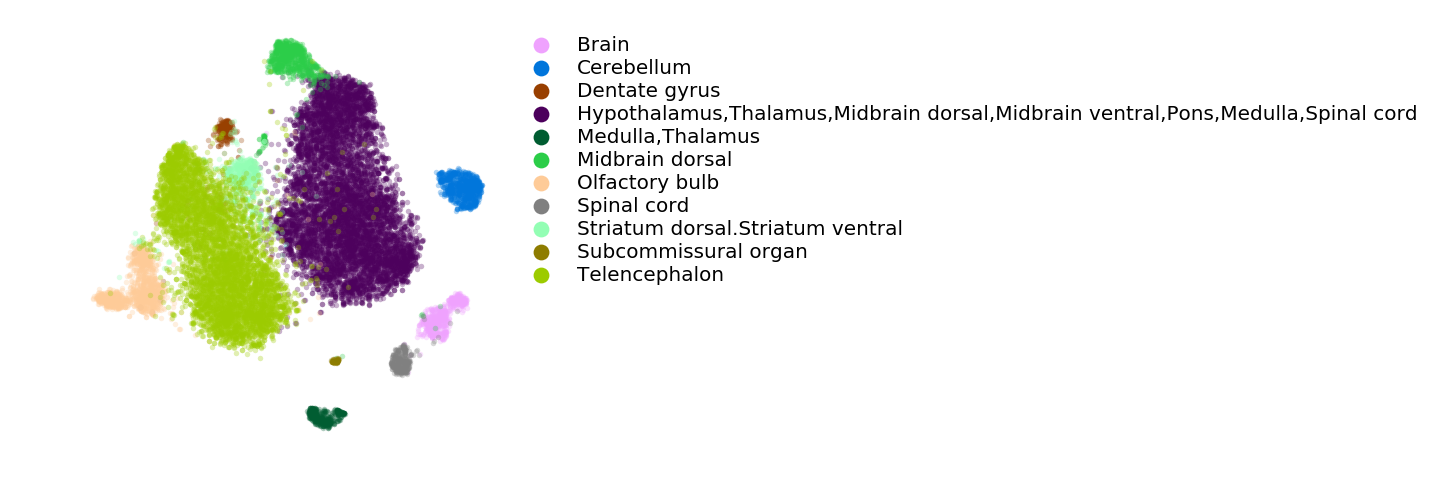

In [25]:
with loompy.connect("/Users/sten/build_20171205/L6_R3_(Astroependymal cells).loom") as ds:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.arange(52))
    ix = 0
    for ct in np.unique(ds.ca.Region):
        cells = ds.ca.Region == ct
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=30,c=colors[ix], marker='.', label=ct,alpha=0.3, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
    plt.savefig("Astroependymal_regions.pdf", bbox_inches='tight')

In [6]:
with loompy.connect("/Users/sten/build_20171205/L6_R3_(Astroependymal cells).loom") as ds:
    print(ds.ca.last_modified())
    for gene in ["Agt", "Mfge8", "Slc6a9", "Lhx2", "Hapln1", "Islr2", "Hs3st3a1", "Gfap", "Aqp4", "Myoc", "Slc6a11", "Islr", "Mfge8", "Gdf10"]:
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_axes([0,0,1,1])
        ax.axis('off')
        cells = ds[ds.ra.Gene == gene, :][0]==0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=30,c="lightgrey",marker='.',alpha=0.7, lw=0)
        cells = ds[ds.ra.Gene == gene, :][0]!=0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=10,c=np.log(ds[ds.ra.Gene == gene, :][0][cells]),marker='.',alpha=0.7, lw=0)
        plt.savefig(f"Astroependymal_{gene}.png", dpi=300, transparent=True, bbox_inches='tight')
        plt.close()

20180131T154625.155054Z


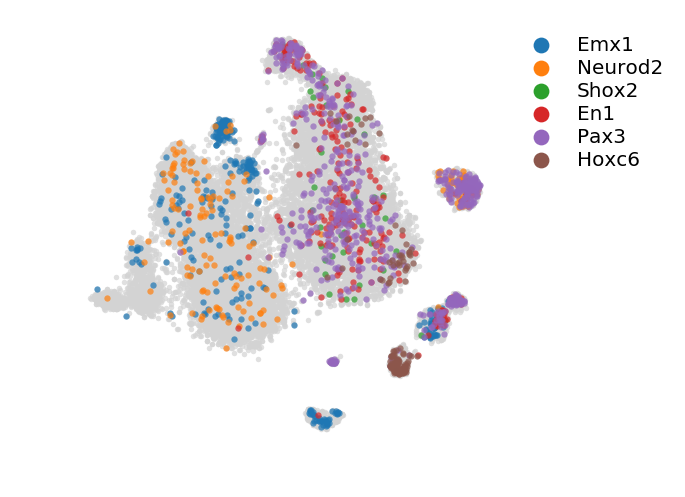

In [46]:
with loompy.connect("/Users/sten/build_20171205/L6_R3_(Astroependymal cells).loom") as ds:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.arange(52))
    colors = plt.cm.tab10.colors
    ix = 0
    plt.scatter(x=ds.ca._X, y=ds.ca._Y, s=30,c="lightgrey",marker='.',alpha=0.7, lw=0)
    for gene in ["Emx1", "Neurod2", "Shox2","En1", "Pax3", "Hoxc6"]:
        cells = ds[ds.ra.Gene == gene, :][0]!=0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=40,c=colors[ix],marker='.',label=gene,alpha=0.7, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
    plt.savefig("Astroependymal_patterning.pdf", bbox_inches='tight')

In [ ]:
with loompy.connect("/Users/sten/build_20171205/F_Neurogenesis/F_Neurogenesis.loom") as ds:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.arange(52))
    ix = 0
    for ct in np.unique(ds.ca.ClusterName):
        cells = ds.ca.ClusterName == ct
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=30,c=colors[ix], marker='.', label=ct,alpha=0.3, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
    plt.savefig("Neurogenesis_by_tissue.pdf", bbox_inches='tight')

In [16]:
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    print(ds.ra.Accession[ds.ra.Gene == "U2af1l4"])

['ENSMUSG00000109378' 'ENSMUSG00000078765']


In [50]:
with loompy.connect("/Users/sten/build_20171205/F_Neurogenesis/F_Neurogenesis.loom") as ds:
    print(ds.ca.last_modified())
    for gene in ["Aqp4", "Igfbpl1", "Eomes", "Riiad1", "Ascl1", "Slc17a7", "Slc32a1", "Top2a", "Fabp7", "Tfap2c"]:
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_axes([0,0,1,1])
        ax.axis('off')
        cells = ds[ds.ra.Gene == gene, :][0]==0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=80,c="lightgrey",marker='.',alpha=0.7, lw=0)
        cells = ds[ds.ra.Gene == gene, :][0]!=0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=40,c=np.log(ds[ds.ra.Gene == gene, :][0][cells]),marker='.',alpha=0.7, lw=0)
        plt.savefig(f"Neurogenesis_{gene}.png", dpi=300, transparent=True, bbox_inches='tight')
        plt.close()

20180130T172221.743384Z


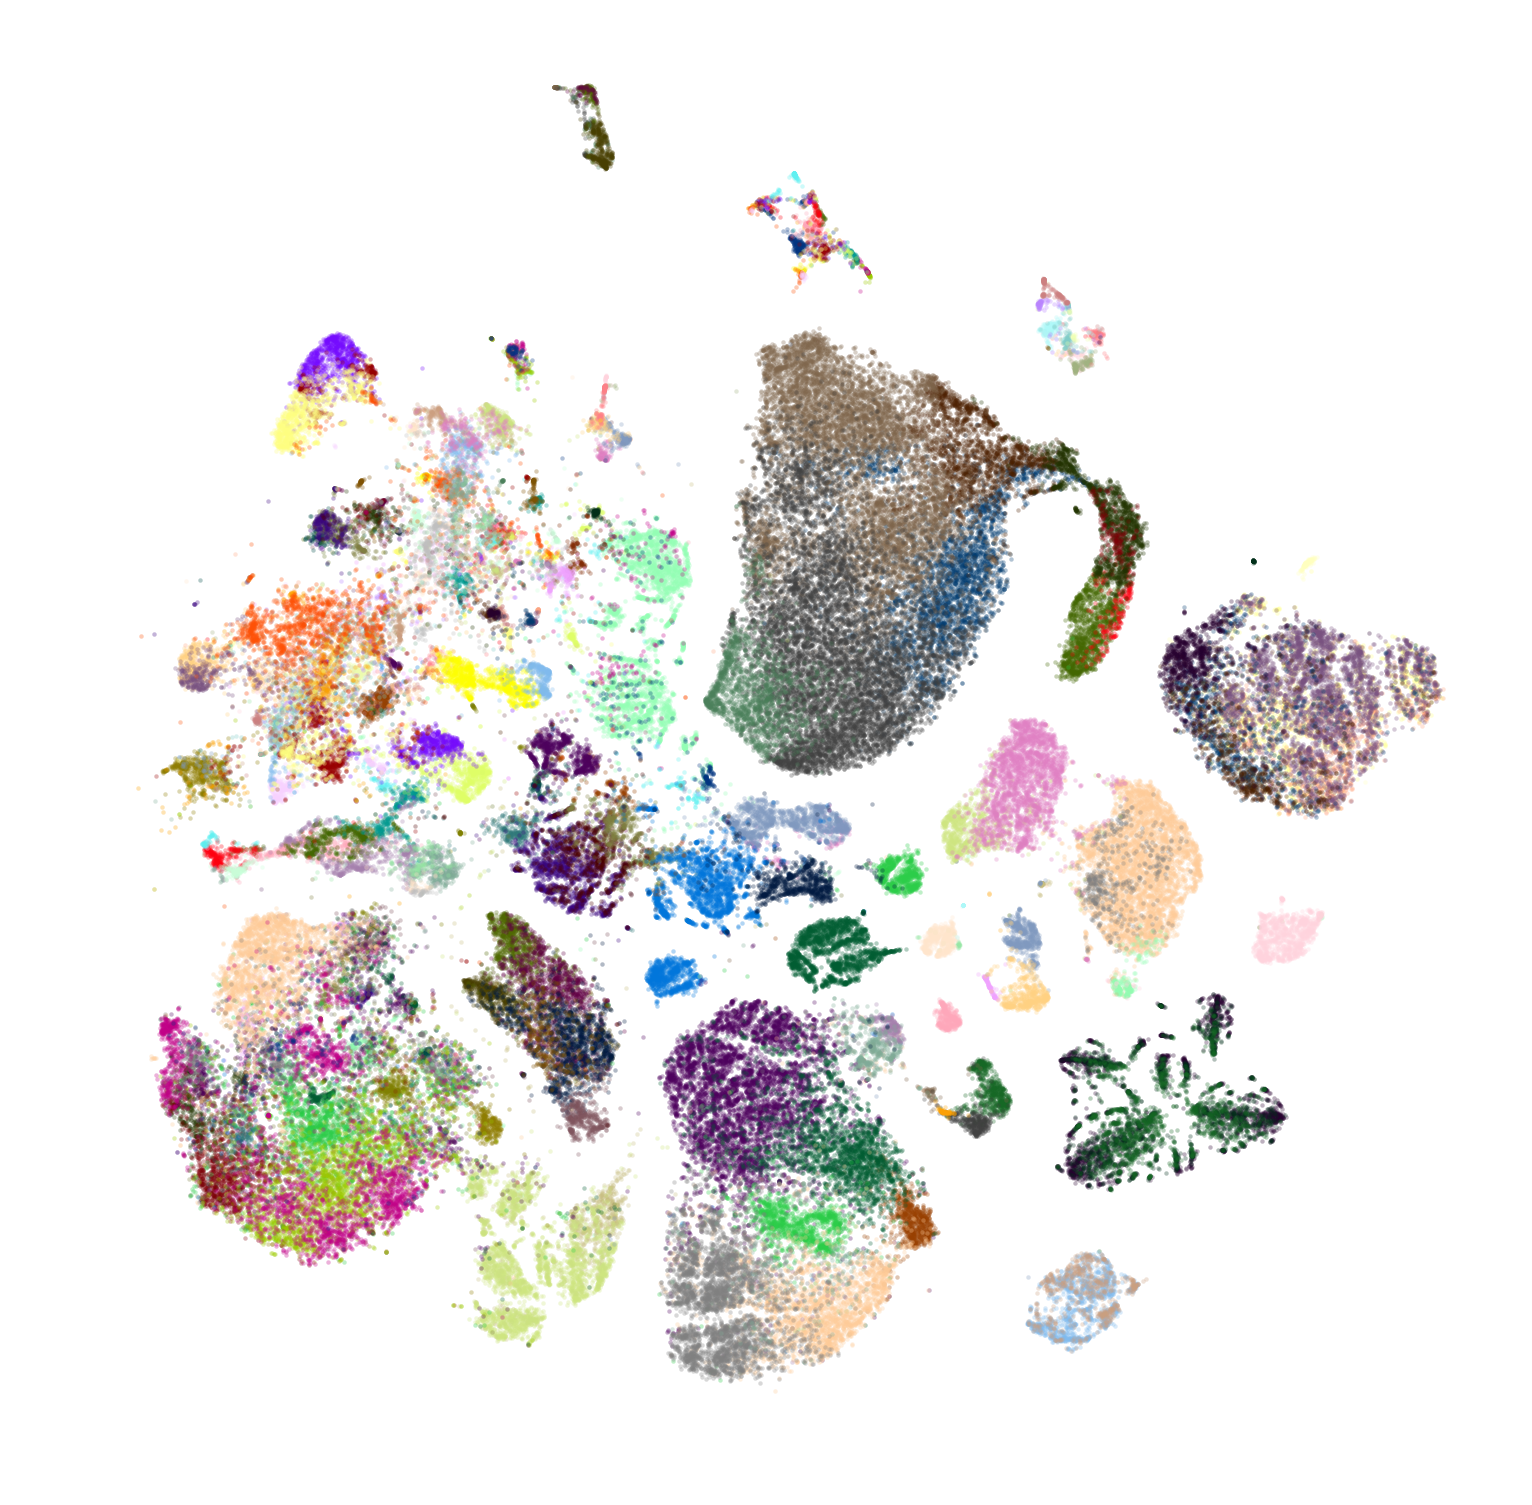

In [57]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.arange(52))
    ix = 0
    for taxon in np.unique(ds.ca.ClusterName):
        cells = ds.ca.ClusterName == taxon
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=20,c=cg.colors75[np.mod(ix, 75)], marker='.', label=taxon,alpha=0.3, lw=0)
        ix += 1
#        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
#        for handle in lgnd.legendHandles:
#            handle.set_sizes([250])
#            handle.set_alpha(1)
    plt.savefig("AllCells.png", dpi=600, transparent=True)

In [15]:
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    print((ds.ca.ClusterName == "NFOL2").sum())
    for gene in ["Pdgfra", "Top2a", "Bmp4", "Itpr2", "Cdk1", "Tmem2", "Sox10", "Emx1", "Neurod1", "Neurod2", "Shox2", "Tal1", "En1", "Pax3", "Hoxb8", "Hoxc6", "Mog"]:
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_axes([0,0,1,1])
        ax.axis('off')
        cells = ds[ds.ra.Gene == gene, :][0]==0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=50,c="lightgrey",marker='.',alpha=0.7, lw=0)
        cells = ds[ds.ra.Gene == gene, :][0]!=0
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=80,c=np.log(ds[ds.ra.Gene == gene, :][0][cells]),marker='.',alpha=0.7, lw=0)
        plt.savefig(f"Oligos_{gene}.png", dpi=300, transparent=True, bbox_inches='tight')
        plt.close()

181


(27998, 37200)


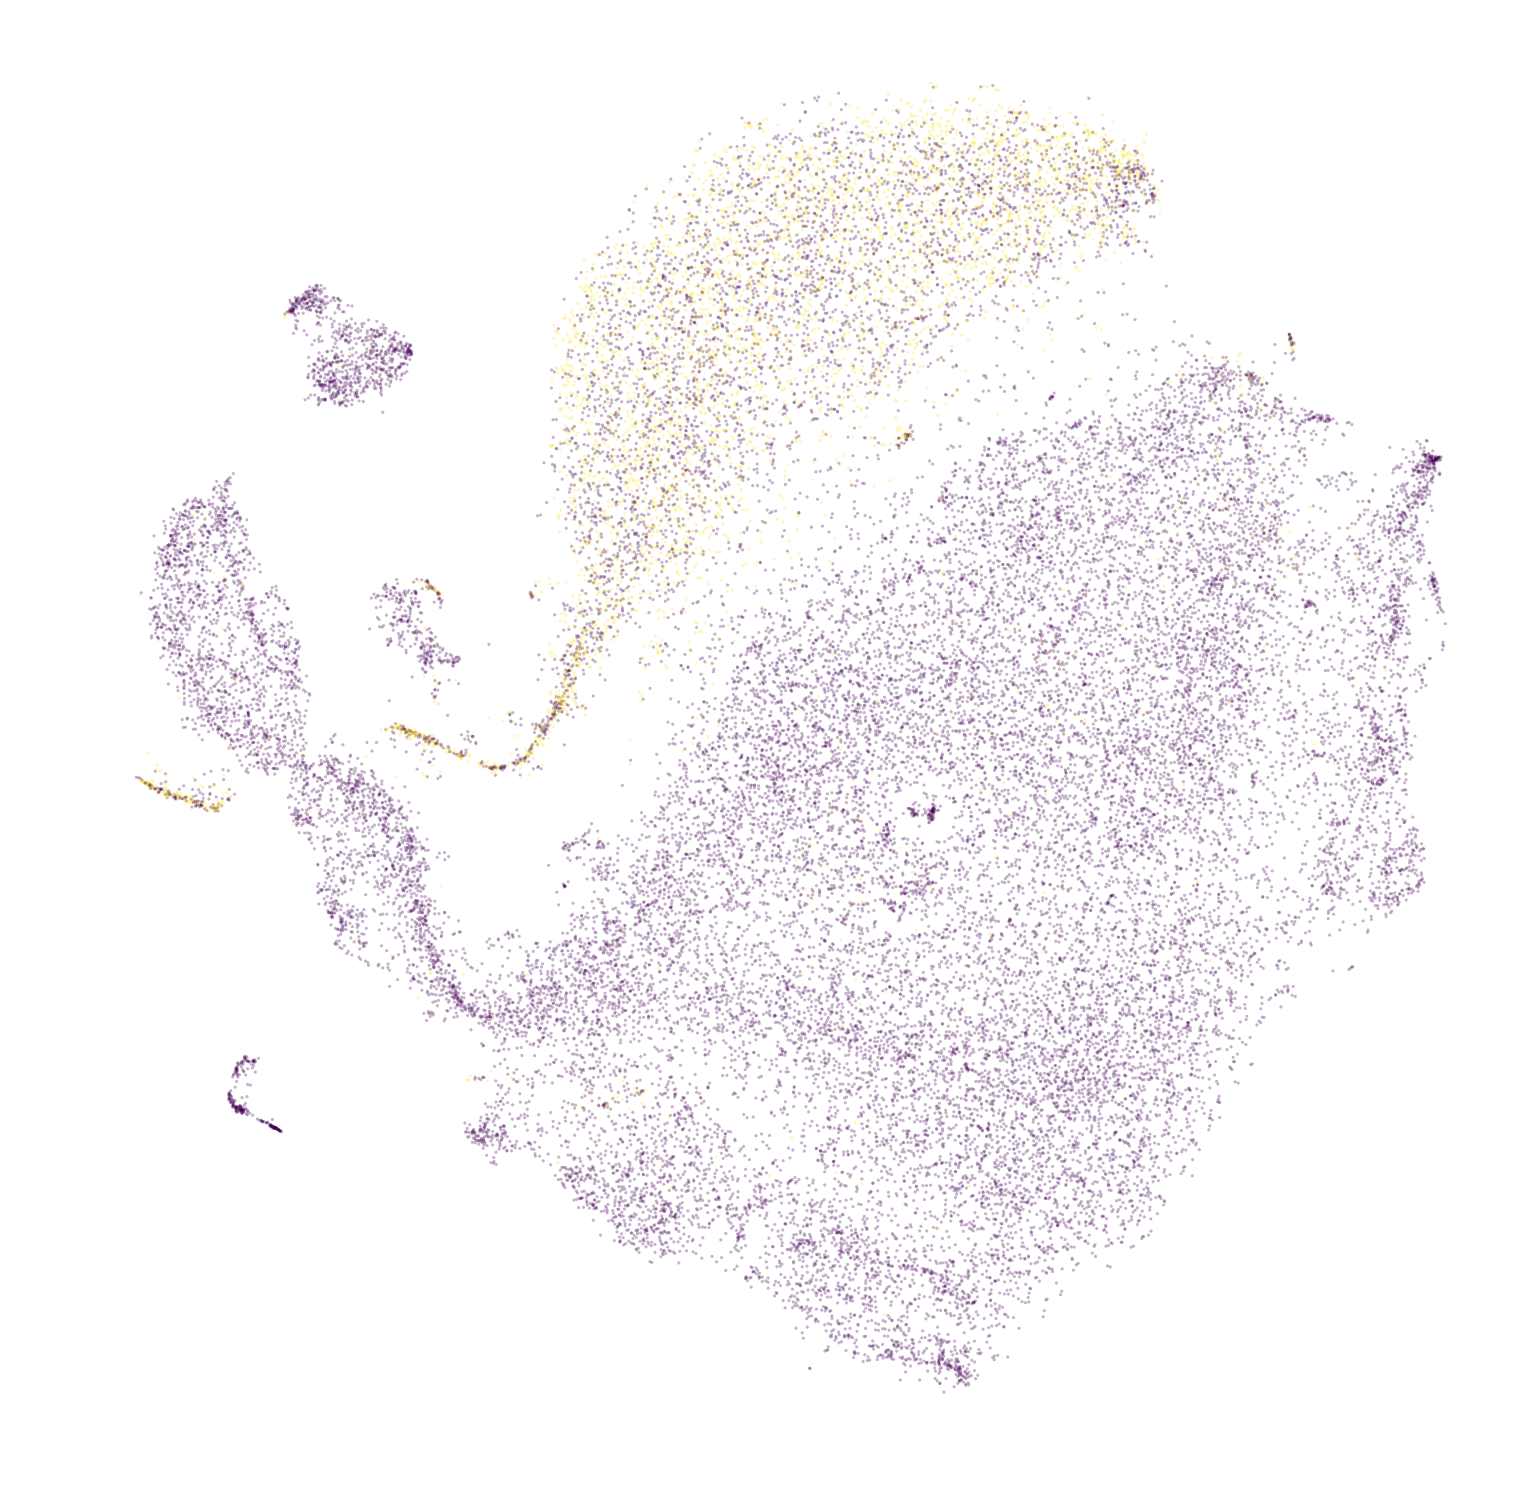

In [113]:
with loompy.connect("/Users/sten/build_20171205/L2_Oligos_All.loom") as ds:
    print(ds.shape)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    plt.scatter(x=ds.ca._X, y=ds.ca._Y, s=10,c=ds.ca.Tissue == "Pons", marker='.', alpha=0.3, lw=0)


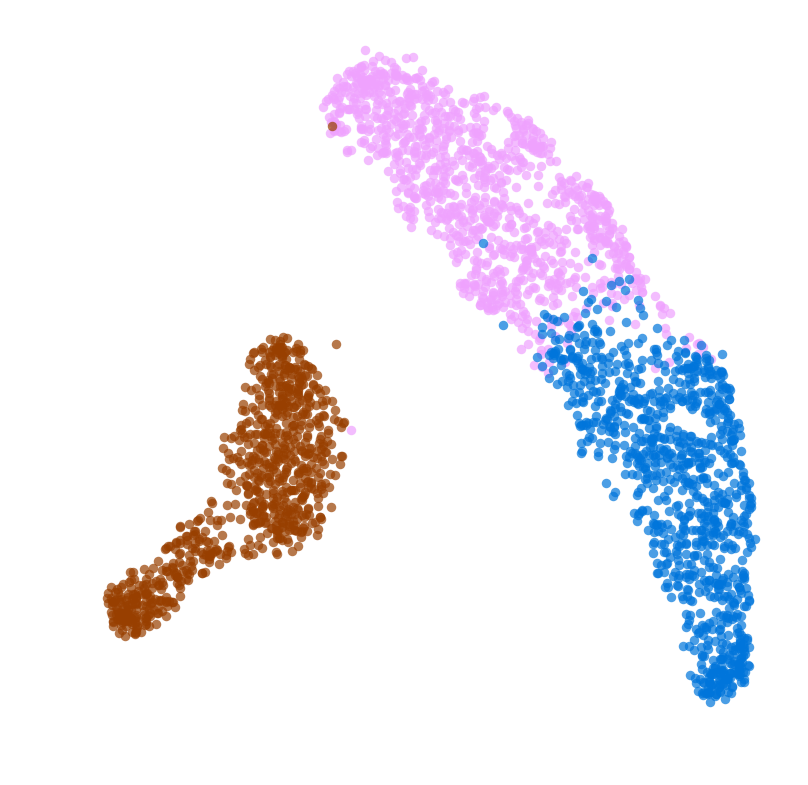

In [27]:
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colors75[(0,0,1,1,2),:] 
    ix = 0
    for taxon in np.unique(ds.ca.ClusterName):
        cells = ds.ca.ClusterName == taxon
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=90,c=colors[np.mod(ix, 75)], marker='.', label=taxon,alpha=0.7, lw=0)
        ix += 1
#        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
#        for handle in lgnd.legendHandles:
#            handle.set_sizes([250])
#            handle.set_alpha(1)
plt.savefig("Oligos_byname.png", dpi=600, transparent=True)

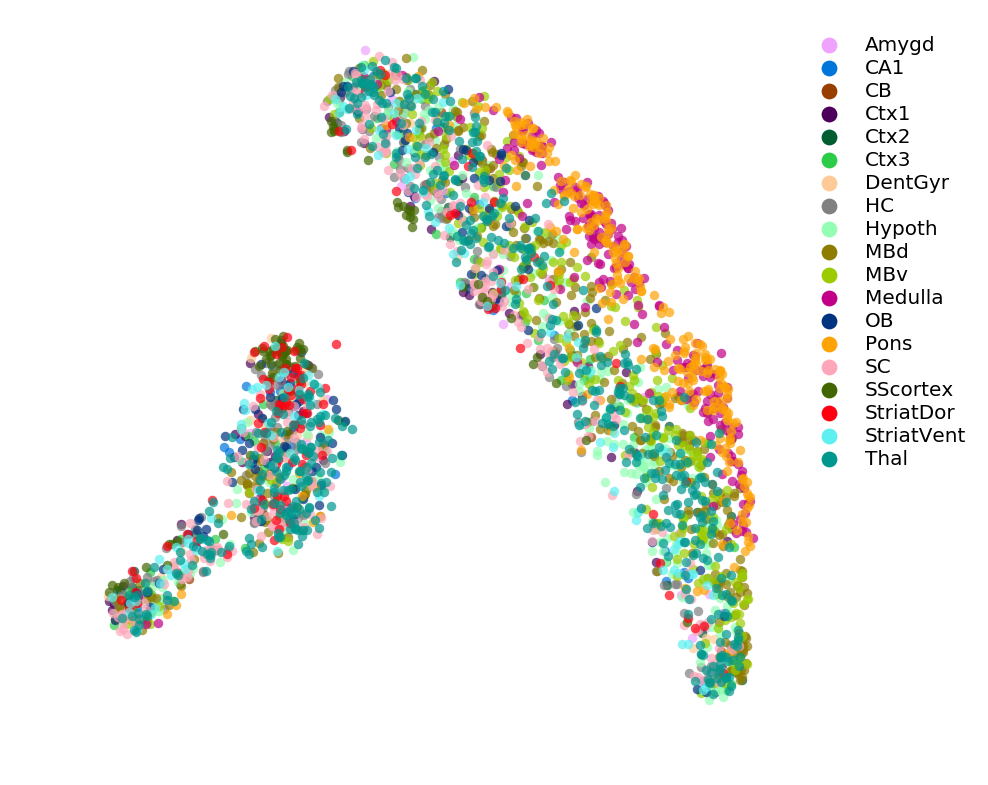

In [34]:
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colors75
    ix = 0
    for taxon in np.unique(ds.ca.Tissue):
        cells = ds.ca.Tissue == taxon
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=90,c=colors[np.mod(ix, 75)], marker='.', label=taxon,alpha=0.7, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
#plt.savefig("Oligos_bytissue.pdf", dpi=600, transparent=True, bbox_inches='tight')

In [53]:
# Gene enrichment in groups defined by patterning TFs
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    markers = ["Emx1", "Neurod1", "Neurod2", "Shox2", "Tal1", "En1", "Pax3", "Hoxb8", "Hoxc6"]
    labels = np.zeros(ds.shape[1], dtype='int')
    for ix, marker in enumerate(markers):
        labels[ds[ds.ra.Gene == marker, :][0] > 0] = ix + 1
    clusters = ds.ca.Clusters
    ds.ca.Clusters = labels
    (genes, enrichment, enrichment_q) = cg.MarkerSelection().fit(ds)
    ds.ca.Clusters = clusters
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    for ix in range(1, enrichment.shape[1]):
        print(markers[ix - 1], ds.ra.Gene[np.argsort(-enrichment[:, ix])][:10][enrichment_q[:,ix][np.argsort(-enrichment[:, ix])][:10] < 0.1])

2018-02-13 21:57:53,148 INFO:Computing enrichment statistic 
2018-02-13 21:58:17,827 INFO:Computing enrichment null distribution 
2018-02-13 21:58:41,989 INFO:Computing enrichment FDR-corrected P values 


In [129]:
# Fraction expression in neurons, oligos and astroependymal
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    print(ds.shape)
    gene = "Onecut2"
    expr = ds[ds.ra.Gene == gene, :][0]
    neurons = ds.ca.TaxonomyRank2 == "CNS neurons"
    oligos = (ds.ca.TaxonomyRank3 == "Oligodendrocytes") | (ds.ca.TaxonomyRank4 == "Oligodendrocyte precursor cells")
    astros = ds.ca.TaxonomyRank3 == "Astroependymal cells"
    tissue = ds.ca.Tissue

print(gene)
a=np.count_nonzero(expr[oligos])
b=oligos.sum()
print(a,b,a/b)
a=np.count_nonzero(expr[neurons])
b=neurons.sum()
print(a,b,a/b)
a=np.count_nonzero(expr[astros])
b=astros.sum()
print(a,b,a/b)

(27998, 160796)
Onecut2
4231 31073 0.136163228526
2536 70968 0.0357344155112
39 22286 0.00174997756439


In [122]:
# Enrichment in groups defined by tissue
with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    tissues = {
        'Amygd': 0,
        'CA1': 0,
        'CB': 3,
        'Ctx1': 0,
        'Ctx2': 0,
        'Ctx3': 0,
        'DentGyr': 0,
        'HC': 0,
        'Hypoth': 1,
        'MBd': 2,
        'MBv': 2,
        'Medulla': 3,
        'OB': 0,
        'Pons': 3,
        'SC': 4,
        'SScortex': 0,
        'StriatDor': 0,
        'StriatVent': 0,
        'Thal': 1
    }
    labels = np.zeros(ds.shape[1], dtype='int')
    for tissue, label in tissues.items():
        labels[ds.ca.Tissue == tissue] = label
    clusters = ds.ca.Clusters
    ds.ca.Clusters = labels
    (genes, enrichment, enrichment_q) = cg.MarkerSelection().fit(ds)
    ds.ca.Clusters = clusters


2018-02-14 10:10:26,097 INFO:Computing enrichment statistic 
2018-02-14 10:10:50,287 INFO:Computing enrichment null distribution 
2018-02-14 10:11:15,209 INFO:Computing enrichment FDR-corrected P values 


0 Hes5
0 Foxg1
0 Mef2c
0 Hes1
0 Id3
0 Lhx2
0 Dmrta2
0 Fos
0 Zfp36l1
0 Meis2
1 Six3
1 Rora
1 Zic1
1 Scrt1
1 Shox2
1 Zc3h11a
1 Bola3
1 Zmat4
1 Foxk2
1 Plagl2
2 Onecut2
2 Zfp740
2 Smad7
2 Zfp62
2 Zbtb7b
2 Crebzf
2 Creb5
2 En1
2 Zfp536
2 Arid3b
3 Skil
3 Tcf7l2
3 Bach2
3 Sox2
3 Tcf7l1
3 Lcor
3 Zfp608
3 Zfp799
3 Zfp780b
3 Lcorl
4 Hoxa7
4 Hoxb7
4 Hoxd8
4 Hoxc8
4 Hoxc10
4 Hoxa9
4 Hoxb2
4 Hoxc6
4 Meox1
4 Hoxd9


In [128]:

with loompy.connect("/Users/sten/build_20171205/F_Oligos/F_Oligos.loom") as ds:
    for ix in range(5):
        ordering = np.argsort(-enrichment[:, ix])
        genes = ds.ra.Gene[ordering]
        scores = enrichment_q[:, ix][ordering]
        n_genes = 0
        for j, gene in enumerate(genes):
            if gene in cg.TFs:
                if scores[j] < 0.1:
                    print(ix, gene)
                n_genes += 1
            if n_genes > 25:
                break

0 Hes5
0 Foxg1
0 Mef2c
0 Hes1
0 Id3
0 Lhx2
0 Dmrta2
0 Fos
0 Zfp36l1
0 Meis2
0 Etv4
0 Rxrg
0 Junb
0 Nr2e1
0 Dmrtb1
0 Prrx1
0 Id2
0 Bcl11b
0 Rfx4
0 Eno1
0 Mxd3
0 Zeb1
0 Smarcd3
0 Pou3f2
0 Sox5
0 Neurod2
1 Six3
1 Rora
1 Zic1
1 Scrt1
1 Shox2
2 Onecut2
2 Zfp740
2 Smad7
2 Zfp62
2 Zbtb7b
2 Crebzf
2 Creb5
2 En1
2 Zfp536
2 Arid3b
2 Utf1
2 Plag1
2 Zfp251
2 Pknox2
2 Dach2
2 Irx5
2 Foxn3
2 Stat2
2 Rbpj
2 Zfp488
2 D630045J12Rik
2 Prox1
2 Zfp248
2 E4f1
2 Zfp58
2 Adnp2
3 Skil
3 Tcf7l2
3 Bach2
3 Sox2
3 Tcf7l1
3 Lcor
3 Zfp608
3 Zfp799
3 Zfp780b
3 Lcorl
3 Zfp26
3 Zfp280c
3 Klf13
3 St18
3 Hsf2
3 Ikzf5
3 Mitf
3 Ncor2
3 Zfp280d
3 Heyl
3 Tcf12
3 Arid1a
3 Rc3h2
3 Gatad1
3 Zfp365
3 Zfp516
4 Hoxa7
4 Hoxb7
4 Hoxd8
4 Hoxc8
4 Hoxc10
4 Hoxa9
4 Hoxb2
4 Hoxc6
4 Meox1
4 Hoxd9
4 Heyl
4 Hoxd4
4 Hoxc4
4 Hoxa10
4 Hoxb8
4 Hoxa5
4 Msx1
4 Mafb
4 Ascl1
4 Irx3
4 Prdm8
4 Hoxb6
4 Pax3
4 Ebf1
4 Hoxa3
4 Ets1


## Analysis of Hox gene expression by cluster

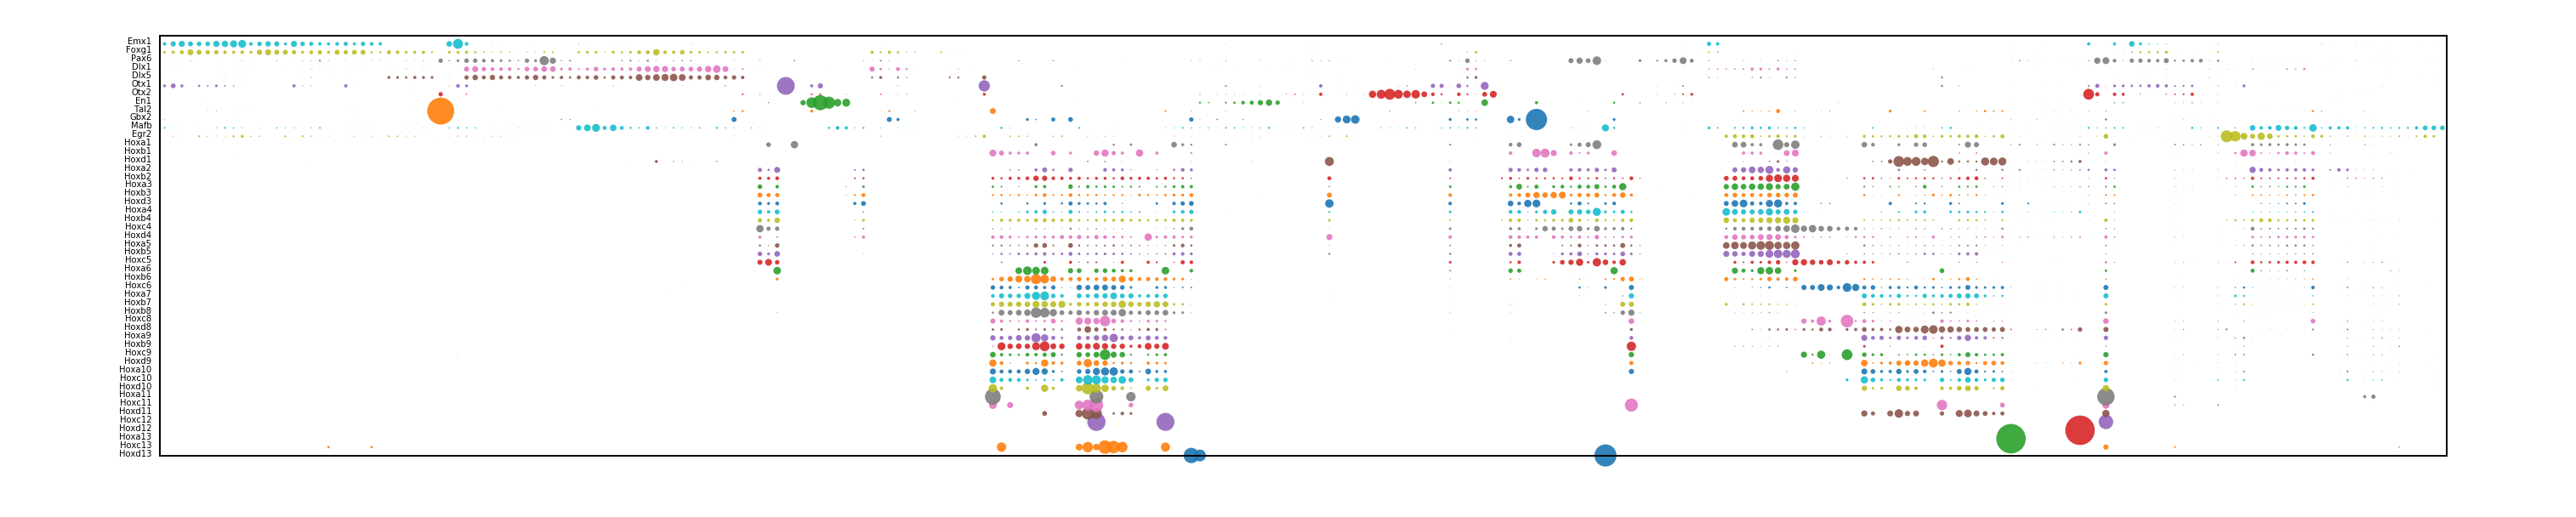

In [4]:
hox_genes = [
    'Emx1',
    'Foxg1',
    'Pax6',
    'Dlx1',
    'Dlx5',
    'Otx1',
    'Otx2',
    'En1',
    'Tal2',
    'Gbx2',
    'Mafb',
    'Egr2',
    'Hoxa1',
    'Hoxb1',
    'Hoxd1',
    'Hoxa2',
    'Hoxb2',
    'Hoxa3',
    'Hoxb3',
    'Hoxd3',
    'Hoxa4',
    'Hoxb4',
    'Hoxc4',
    'Hoxd4',
    'Hoxa5',
    'Hoxb5',
    'Hoxc5',
    'Hoxa6',
    'Hoxb6',
    'Hoxc6',
    'Hoxa7',
    'Hoxb7',
    'Hoxb8',
    'Hoxc8',
    'Hoxd8',
    'Hoxa9',
    'Hoxb9',
    'Hoxc9',
    'Hoxd9',
    'Hoxa10',
    'Hoxc10',
    'Hoxd10',
    'Hoxa11',
    'Hoxc11',
    'Hoxd11',
    'Hoxc12',
    'Hoxd12',
    'Hoxa13',
    'Hoxc13',
    'Hoxd13']
hox_genes.reverse()
fig = plt.figure(figsize=(265/10,len(hox_genes)/10))
ax = fig.add_subplot(111)
ax.axis("off")
ax.add_patch(patches.Rectangle((0,0), 265, len(hox_genes), fill=False))
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
#    print(ds.ca.ClusterName[ordering])
    n_clusters = ds.shape[1]
    for ix,hox in enumerate(hox_genes):
        vals = ds[ds.ra.Gene == hox, :][0][ordering]
        vals = vals / vals.sum()
        plt.scatter(np.arange(n_clusters) + 0.5, np.zeros(n_clusters) + ix, s=300*np.array(vals), alpha=0.9, lw=0)
        plt.text(-1, ix, hox, horizontalalignment='right', fontsize=5)

plt.savefig("hox_genes.pdf", bbox_inches='tight')

In [22]:
restricted = []
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    for tf in cg.TFs:
        if tf not in ds.ra.Gene:
            continue
        gix = np.where(ds.ra.Gene == tf)[0]
        n_clusters = (ds["trinaries"][gix, :] > 0.95).sum()
        if n_clusters >= 1 and n_clusters < 5:
            restricted.append(tf)

In [23]:
for j in range(0, len(restricted), 25):
    hox_genes = restricted[j:j+25]
    fig = plt.figure(figsize=(265/10,len(hox_genes)/10))
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.add_patch(patches.Rectangle((0,0), 265, len(hox_genes), fill=False))
    with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
        ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
    #    print(ds.ca.ClusterName[ordering])
        n_clusters = ds.shape[1]
        for ix,hox in enumerate(hox_genes):
            vals = ds[ds.ra.Gene == hox, :][0][ordering]
            vals = vals / vals.sum()
            plt.scatter(np.arange(n_clusters) + 0.5, np.zeros(n_clusters) + ix + 0.5, s=300*np.array(vals), alpha=0.9, lw=0)
            plt.text(-1, ix, hox, horizontalalignment='right', fontsize=5)
    plt.savefig(f"very_restricted_tfs_{j}.pdf", bbox_inches='tight')
    plt.close()

/Users/sten/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [10]:
restricted_tfs = pd.read_excel("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/TF_analysis/Restricted_TFs.xlsx")
for family in np.unique(restricted_tfs["Family"].values):
    if family == "UNKNOWN":
        continue
    genes = restricted_tfs["Gene"].values[restricted_tfs["Family"].values == family]
    
    # Figure out the gene order
    gene_scores = np.zeros(genes.shape[0])
    with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
        ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
        n_clusters = ds.shape[1]
        for ix,gene in enumerate(genes):
            vals = ds[ds.ra.Gene == gene, :][0][ordering]
            vals = vals / vals.sum()
            vals = vals * np.power(np.arange(n_clusters), 2)
            gene_scores[ix] = np.sum(vals)
    print(family)
    gene_order = np.argsort(-gene_scores)
    
    fig = plt.figure(figsize=(265/10,len(genes)/10))
    ax = fig.add_subplot(111)
    ax.axis("off")
#    ax.add_patch(patches.Rectangle((0,0), 265, len(genes), fill=False))
    with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
        ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
    #    print(ds.ca.ClusterName[ordering])
        n_clusters = ds.shape[1]
        for ix,gene in enumerate(genes[gene_order]):
            vals = ds[ds.ra.Gene == gene, :][0][ordering]
            vals = vals / vals.sum()
            plt.scatter(np.arange(n_clusters) + 0.5, np.zeros(n_clusters) + ix + 0.5, s=300 * vals, lw=0)
            plt.text(-1, ix, gene, horizontalalignment='right', fontsize=5)
    for j in [0, 32, 37, 66, 82, 97, 118, 140,156, 171, 177, 181, 190, 197, 214, 223, 239, 250, 260, 265]:
        ax.add_patch(patches.Polygon([[j, 0],[j, len(hox_genes)-1]], lw=0.5, edgecolor='lightgrey', zorder=-10))
    plt.savefig(f"{family}.pdf", bbox_inches='tight')
    plt.close()


E set domains
Glucocorticoid receptor-like (DNA-binding domain)
HLH helix-loop-helix DNA-binding domain
HMG-box
Homeodomain-like
Hox cluster
Leucine zipper domain
Other
SMAD MH1 domain
Winged helix DNA-binding domain
Zinc fingers
p53-like transcription factors


In [ ]:
hox_genes = [
    'Emx1',
    'Foxg1',
    'Pax6',
    'Dlx1',
    'Dlx5',
    'En1',
    'Lhx9',
    'Otx2',
    'Barhl2',
    'Hoxa1',
    'Hoxb1',
    'Hoxd1',
    'Hoxa2',
    'Hoxb2',
    'Hoxa3',
    'Hoxb3',
    'Hoxd3',
    'Hoxa4',
    'Hoxb4',
    'Hoxc4',
    'Hoxd4',
    'Hoxa5',
    'Hoxb5',
    'Hoxc5',
    'Hoxa6',
    'Hoxb6',
    'Hoxc6',
    'Hoxa7',
    'Hoxb7',
    'Hoxb8',
    'Hoxc8',
    'Hoxd8',
    'Hoxa9',
    'Hoxb9',
    'Hoxc9',
    'Hoxd9',
    'Hoxa10',
    'Hoxc10',
    'Hoxd10',
    'Hoxa11',
    'Hoxc11',
    'Hoxd11',
    'Hoxc12',
    'Hoxd12',
    'Hoxa13',
    'Hoxc13',
    'Hoxd13',
    'Sox10',
    'Foxc1',
    'Foxc2',
    'Meox1',
    'Hhex',
    'Lyl1'
]
colors = [0,0,1,1,1,2,2,20,20,3,3,4,4,4,6,6,6,7,7,7,7,8,8,8,9,9,9,10,10,11,11,11,12,12,12,12,13,13,13,14,14,14,15,15,16,16,16,17, 5,5, 5,18,18]
hox_genes.reverse()
colors.reverse()
fig = plt.figure(figsize=(265/20,len(hox_genes)/10))
ax = fig.add_subplot(111)
ax.axis("off")
#ax.add_patch(patches.Rectangle((0,0), 265, len(hox_genes), fill=False))
with loompy.connect("/data/proj/whole_brain/build_20171205/L5_All.agg.loom") as ds:
    ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
#    print(ds.ca.ClusterName[ordering])
    n_clusters = ds.shape[1]
    n_genes = len(hox_genes)
    for ix,hox in enumerate(hox_genes):
        vals = ds[ds.ra.Gene == hox, :][0][ordering]
        vals = vals / (vals.sum() + 5)
        ax.add_patch(patches.Polygon([[0, ix],[265, ix]], lw=0.5, edgecolor='lightgrey', zorder=-10))
        plt.scatter(np.arange(n_clusters) + 0.5, np.zeros(n_clusters) + ix, c=cg.colors75[colors[ix]], s=300*np.array(vals), alpha=0.9, lw=0)
        plt.text(-0.5, ix-0.3, hox, horizontalalignment='right', fontsize=5)
    for j in [0, 32, 37, 66, 82, 97, 118, 140,156, 171, 177, 181, 190, 197, 214, 223, 239, 250, 260, 265]:
        ax.add_patch(patches.Polygon([[j, 0],[j, len(hox_genes)-1]], lw=0.5, edgecolor='lightgrey', zorder=-10))
plt.savefig("hox_genes.pdf", bbox_inches='tight')

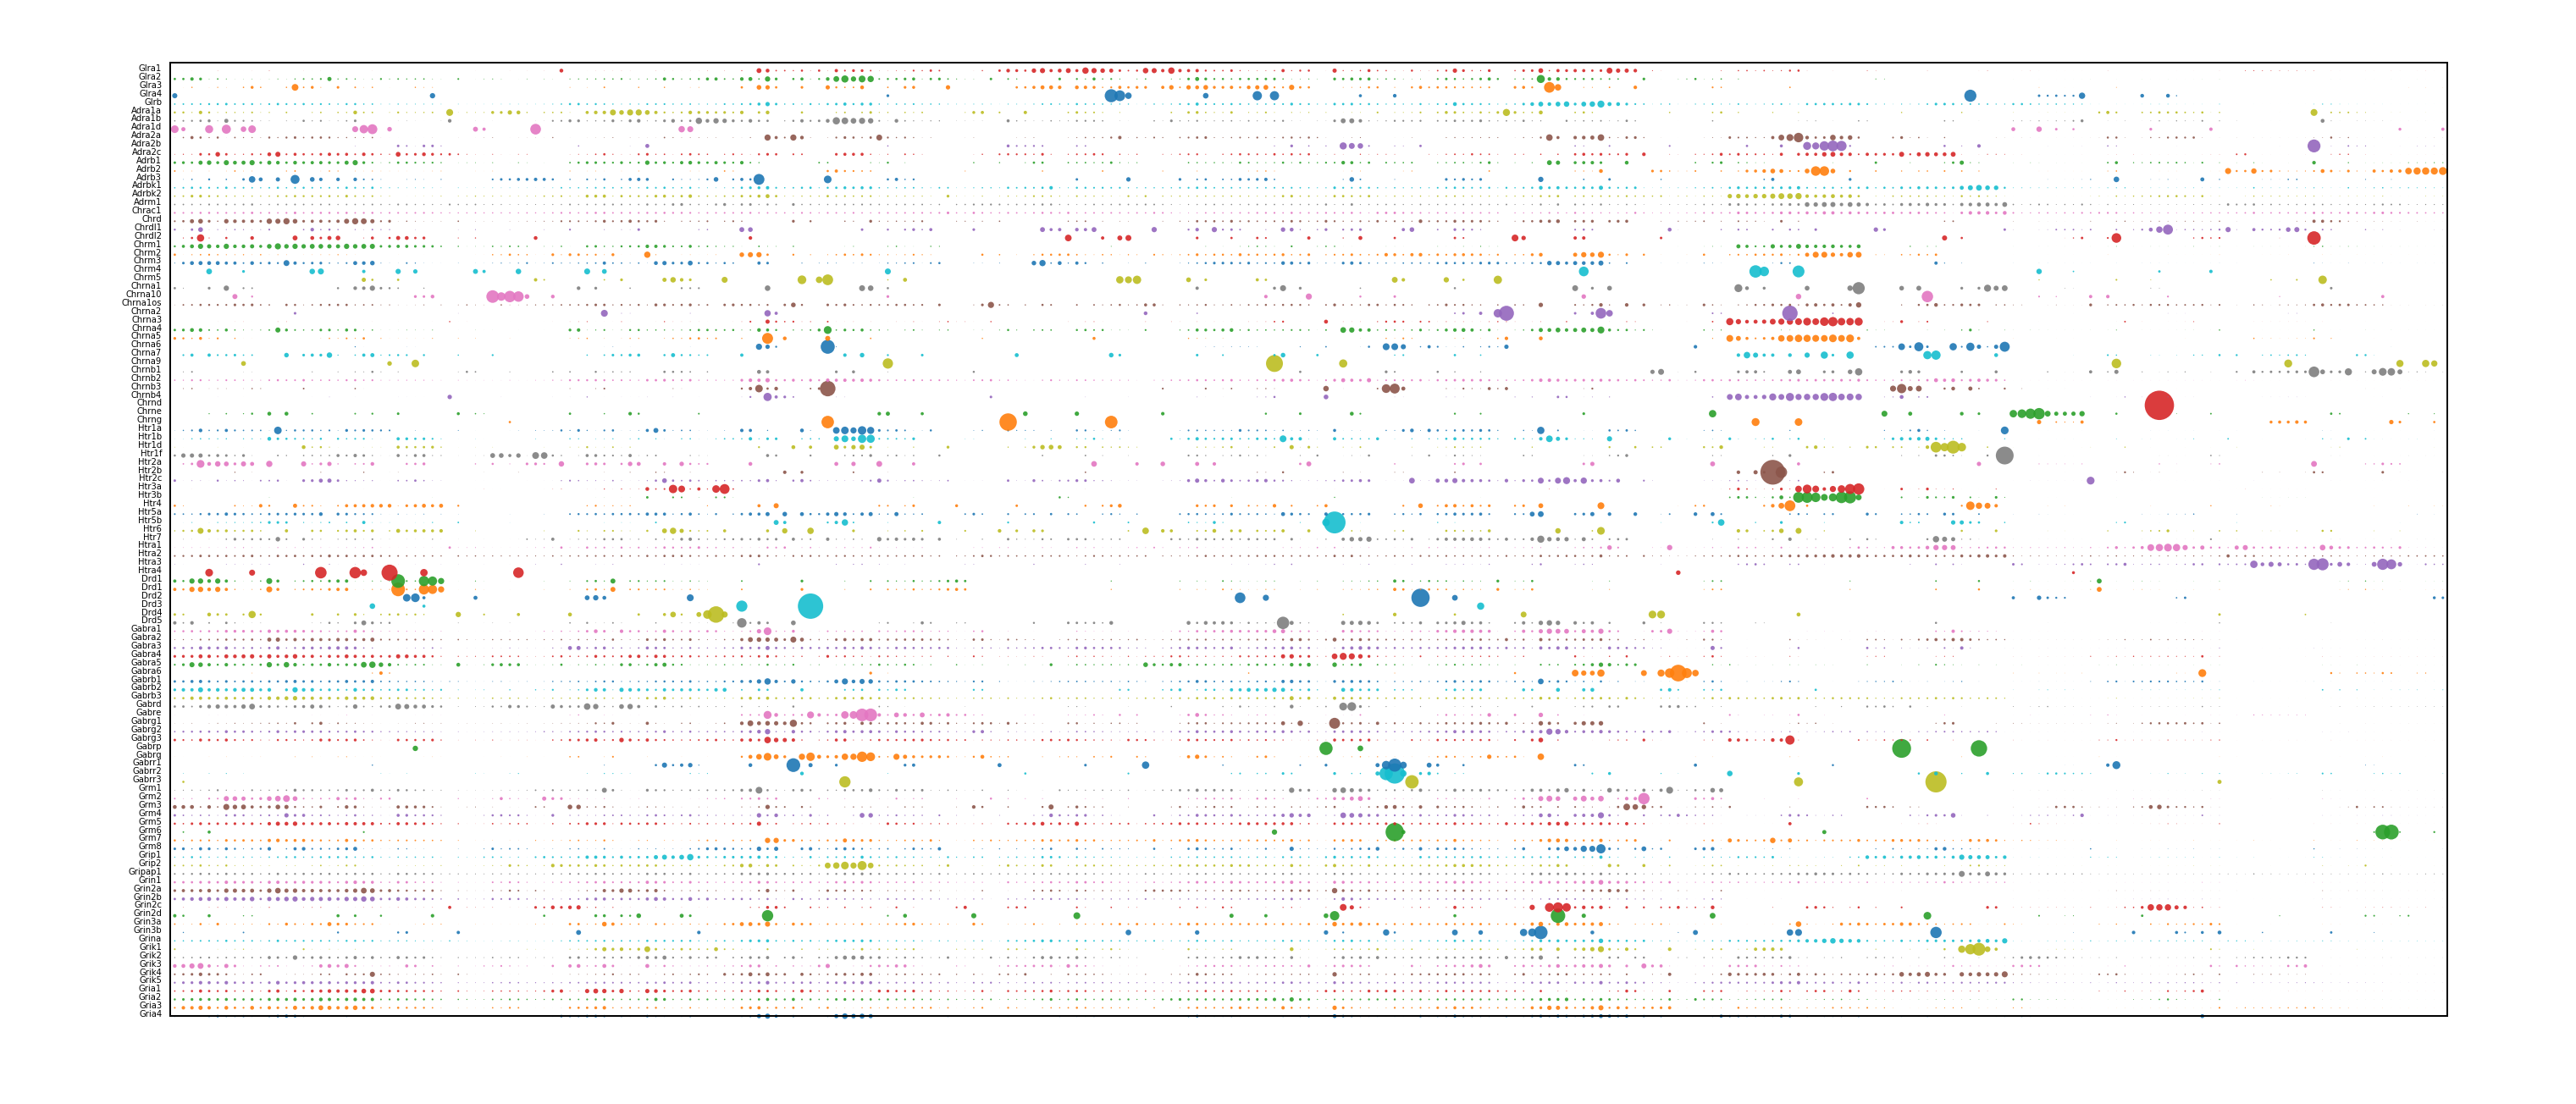

In [5]:
hox_genes = [
    "Glra1",	
    "Glra2",	
    "Glra3",	
    "Glra4",	
    "Glrb",	
    "Adra1a",	
    "Adra1b",	
    "Adra1d",	
    "Adra2a",	
    "Adra2b",	
    "Adra2c",	
    "Adrb1",	
    "Adrb2",	
    "Adrb3",	
    "Adrbk1",	
    "Adrbk2",	
    "Adrm1",	
    "Chrac1",	
    "Chrd",	
    "Chrdl1",	
    "Chrdl2",	
    "Chrm1",	
    "Chrm2",	
    "Chrm3",	
    "Chrm4",	
    "Chrm5",	
    "Chrna1",	
    "Chrna10",	
    "Chrna1os",	
    "Chrna2",	
    "Chrna3",	
    "Chrna4",	
    "Chrna5",	
    "Chrna6",	
    "Chrna7",	
    "Chrna9",	
    "Chrnb1",	
    "Chrnb2",	
    "Chrnb3",	
    "Chrnb4",	
    "Chrnd",	
    "Chrne",	
    "Chrng",	
    "Htr1a",	
    "Htr1b",	
    "Htr1d",	
    "Htr1f",	
    "Htr2a",	
    "Htr2b",	
    "Htr2c",	
    "Htr3a",	
    "Htr3b",	
    "Htr4",	
    "Htr5a",	
    "Htr5b",	
    "Htr6",	
    "Htr7",	
    "Htra1",	
    "Htra2",	
    "Htra3",	
    "Htra4",	
    "Drd1",	
    "Drd1",	
    "Drd2",	
    "Drd3",	
    "Drd4",	
    "Drd5",	
    "Gabra1",	
    "Gabra2",	
    "Gabra3",	
    "Gabra4",	
    "Gabra5",	
    "Gabra6",	
    "Gabrb1",	
    "Gabrb2",	
    "Gabrb3",	
    "Gabrd",	
    "Gabre",	
    "Gabrg1",	
    "Gabrg2",	
    "Gabrg3",	
    "Gabrp",	
    "Gabrq",	
    "Gabrr1",	
    "Gabrr2",	
    "Gabrr3",	
    "Grm1",	
    "Grm2",	
    "Grm3",	
    "Grm4",	
    "Grm5",	
    "Grm6",	
    "Grm7",	
    "Grm8",	
    "Grip1",	
    "Grip2",	
    "Gripap1",	
    "Grin1",	
    "Grin2a",	
    "Grin2b",	
    "Grin2c",	
    "Grin2d",	
    "Grin3a",	
    "Grin3b",	
    "Grina",	
    "Grik1",	
    "Grik2",	
    "Grik3",	
    "Grik4",	
    "Grik5",	
    "Gria1",	
    "Gria2",	
    "Gria3",	
    "Gria4",	
]
hox_genes.reverse()
fig = plt.figure(figsize=(265/10,len(hox_genes)/10))
ax = fig.add_subplot(111)
ax.axis("off")
ax.add_patch(patches.Rectangle((0,0), 265, len(hox_genes), fill=False))
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    ordering = np.argsort(-ds.ca.LeafOrder.astype('int'))
#    print(ds.ca.ClusterName[ordering])
    n_clusters = ds.shape[1]
    for ix,hox in enumerate(hox_genes):
        vals = ds[ds.ra.Gene == hox, :][0][ordering]
        vals = vals / vals.sum()
        plt.scatter(np.arange(n_clusters) + 0.5, np.zeros(n_clusters) + ix, s=300*np.array(vals), alpha=0.9, lw=0)
        plt.text(-1, ix, hox, horizontalalignment='right', fontsize=5)

plt.savefig("nt_receptors.pdf", bbox_inches='tight')

In [107]:
tissue = []
n_cells = []
n_clusters = []
avg_total = []
root = "/Users/sten/build_20171205/"
for f in os.listdir(root):
    if f.startswith("L1_") and f.endswith(".loom") and not f.endswith(".agg.loom"):
        with loompy.connect(os.path.join(root, f)) as ds:
            tissue.append(f[3:-5])
            n_cells.append(ds.shape[1])
            n_clusters.append(np.unique(ds.ca.Clusters).shape[0])
            avg_total.append(np.mean(ds.ca._Total))
for ix, tissue in enumerate(tissue):
    print(f"{tissue:<20}{n_cells[ix]}\t{int(avg_total[ix])}")
print(np.array(n_cells).sum())

Cortex3             15969	3167
Cerebellum          12312	1127
Enteric             17417	3627
Hypothalamus        36836	2192
StriatumVentral     20271	2118
Cortex2             20811	3002
Thalamus            36681	2781
Sympathetic         1490	13354
Olfactory           20636	2036
SpinalCord          37227	3928
Amygdala            25414	1613
MidbrainVentral     37528	2694
MidbrainDorsal      38940	3197
DRG                 2948	8112
Hippocampus         29519	3220
Medulla             65179	3892
Cortex1             13698	3733
Pons                62635	3817
StriatumDorsal      11775	2944
507286


In [102]:
tissue = []
n_cells = []
n_clusters = []
avg_total = []
root = "/Users/sten/build_20171205/"
for f in os.listdir(root):
    if f.startswith("L2_") and f.endswith(".loom") and not f.endswith(".agg.loom") and not f.endswith("Neurons_All.loom"):
        with loompy.connect(os.path.join(root, f)) as ds:
            tissue.append(f[3:-5])
            n_cells.append(ds.shape[1])
            n_clusters.append(np.unique(ds.ca.Clusters).shape[0])
            avg_total.append(np.mean(ds.ca._Total))
for ix, tissue in enumerate(tissue):
    print(f"{tissue:<20}\t{n_cells[ix]}\t{int(avg_total[ix])}")
print(np.array(n_cells).sum())

Oligos_All          	37200	3878
Immune_All          	16830	1408
Ependymal_All       	2730	3358
Neurons_StriatumVentral	10204	2289
PeripheralGlia_All  	15772	3203
Neurons_Medulla     	2273	4745
Neurons_StriatumDorsal	6392	3205
Neurons_Pons        	2807	5681
Neurons_Cortex1     	8138	4575
Neurons_Thalamus    	7904	3900
Neurons_Sympathetic 	1263	14677
Neurons_MidbrainDorsal	8185	3908
Neurons_Hypothalamus	20696	2468
Neurons_Cerebellum  	8354	945
Neurons_MidbrainVentral	5199	3432
Neurons_Olfactory   	10745	1993
Neurons_DRG         	1688	11222
Neurons_Cortex2     	10895	3662
Neurons_Enteric     	1239	9352
Vascular_All        	31054	2620
Neurons_Amygdala    	14897	1906
Astrocytes_All      	38556	1394
Neurons_Hippocampus 	18103	3827
Neurons_Cortex3     	8421	4081
Neurons_SpinalCord  	2760	2895
292305


In [100]:
tissue = []
n_cells = []
n_clusters = []
avg_total = []
root = "/Users/sten/build_20171205/"
for f in os.listdir(root):
    if f.startswith("L3_") and f.endswith(".loom") and not f.endswith(".agg.loom"):
        with loompy.connect(os.path.join(root, f)) as ds:
            tissue.append(f[3:-5])
            n_cells.append(ds.shape[1])
            n_clusters.append(np.unique(ds.ca.Clusters).shape[0])
            avg_total.append(np.mean(ds.ca._Total))
for ix, tissue in enumerate(tissue):
    print(f"{tissue:<20}\t{n_cells[ix]}\t{int(avg_total[ix])}")
print(np.array(n_cells).sum())

Sympathetic_Neurons 	1263	14677
Mesencephalon_Inhibitory	4957	3505
Enteric_Neurons     	1180	9398
SpinalCord_Excitatory	1311	2863
Hindbrain_Excitatory	1579	6133
Ependymal           	2543	3309
Sympathetic_Neurons.filtered	969	15581
Immune              	11057	1367
Vascular            	14672	2807
Telencephalon_Excitatory	24141	4664
Oligos              	33320	3853
Diencephalon_Excitatory	5743	4252
Hindbrain_Inhibitory	2214	3749
Brain_Granule       	13141	1518
SpinalCord_Inhibitory	856	3613
Brain_CholinergicMonoaminergic	1322	7224
Olfactory_Inhibitory	4702	1620
PeripheralGlia      	12382	3181
Mesencephalon_Excitatory	4127	4192
Enteric_Neurons.filtered	695	9954
Diencephalon_Inhibitory	4864	3228
Striatum_MSN        	9898	2603
Sensory_Neurons     	1663	11282
Brain_Neuroblasts   	8019	1885
Astrocytes          	30198	1443
Hypothalamus_Peptidergic	1546	2883
Telencephalon_Inhibitory	20326	3344
218688


In [103]:
tissue = []
n_cells = []
n_clusters = []
avg_total = []
root = "/Users/sten/build_20171205/"
for f in os.listdir(root):
    if f.startswith("L4_") and f.endswith(".loom") and not f.endswith(".agg.loom"):
        with loompy.connect(os.path.join(root, f)) as ds:
            tissue.append(f[3:-5])
            n_cells.append(ds.shape[1])
            n_clusters.append(np.unique(ds.ca.Clusters).shape[0])
            avg_total.append(np.mean(ds.ca._Total))
for ix, tissue in enumerate(tissue):
    print(f"{tissue:<20}\t{n_cells[ix]}\t{int(avg_total[ix])}")
print(np.array(n_cells).sum())

Hindbrain_Excitatory	1236	6247
Brain_Granule       	8561	1638
SpinalCord_Excitatory	1212	2953
Mesencephalon_Inhibitory	2597	3785
Ependymal           	1826	3696
Diencephalon_Inhibitory	1937	4329
Brain_CholinergicMonoaminergic	972	8451
Vascular            	12305	2860
Telencephalon_Excitatory	19021	5098
Sensory_Neurons     	1580	11394
PeripheralGlia      	11217	3194
Mesencephalon_Excitatory	2817	4291
Olfactory_Inhibitory	4112	1635
Striatum_MSN        	7531	3039
SpinalCord_Inhibitory	802	3623
Oligos              	31073	3863
Immune              	7454	1595
Enteric_Neurons     	1105	9447
Sympathetic_Neurons 	886	16193
Hindbrain_Inhibitory	1852	3717
Brain_Neuroblasts   	6831	1972
Telencephalon_Inhibitory	9637	4648
Hypothalamus_Peptidergic	924	3222
Astrocytes          	24991	1504
Diencephalon_Excitatory	3460	4958
165939


In [104]:
tissue = []
n_cells = []
n_clusters = []
avg_total = []
root = "/Users/sten/build_20171205/"
for f in os.listdir(root):
    if f.startswith("L5_") and f.endswith(".loom") and not f.endswith(".agg.loom"):
        with loompy.connect(os.path.join(root, f)) as ds:
            tissue.append(f[3:-5])
            n_cells.append(ds.shape[1])
            n_clusters.append(np.unique(ds.ca.Clusters).shape[0])
            avg_total.append(np.mean(ds.ca._Total))
for ix, tissue in enumerate(tissue):
    print(f"{tissue:<20}\t{n_cells[ix]}\t{int(avg_total[ix])}")
print(np.array(n_cells).sum())

All                 	160796	3446
160796


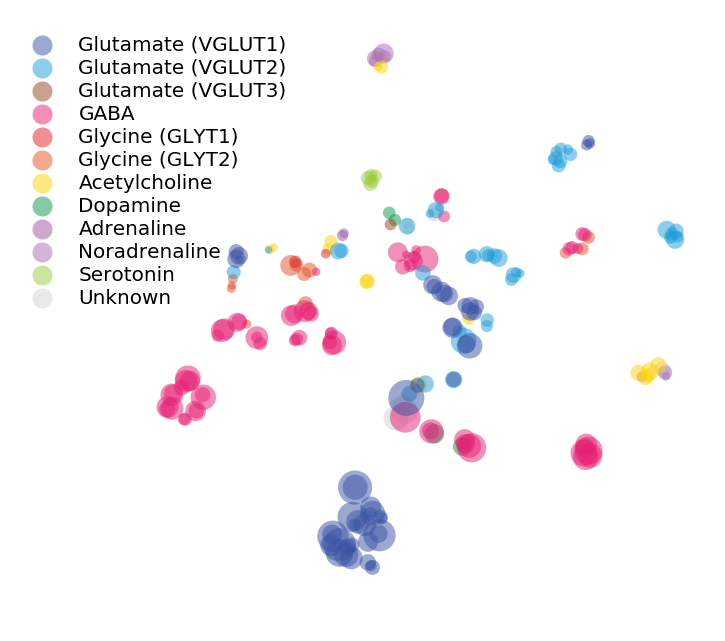

In [18]:
mapping = {
    'Glutamate (VGLUT2),Acetylcholine': "Acetylcholine",
    'GABA, Glycine (GLYT1,GLYT2)': "Glycine (GLYT2)", 
    'Acetylcholine, nitric oxide, noradrenaline': "Noradrenaline",
    'Acetylcholine, Glutamate (VGLUT2)': "Acetylcholine",
    'Acetylcholine,Glutamate (VGLUT2)': "Acetylcholine", 
    'Noradrenergic': "Noradrenaline", 
    'Acetylcholine': "Acetylcholine", 
    'Glutamate (VGLUT1,VGLUT2)': "Glutamate (VGLUT1)", 
    'Noradrenaline': "Noradrenaline", 
    'GABA': "GABA",
    'GABA, Glycine (GLYT1)': "Glycine (GLYT1)", 
    'Nitric oxide, noradrenaline': "Noradrenaline", 
    'GABA,Dopamine': "Dopamine", 
    'Nitric oxide': "Other", 
    'nan': "Other", 
    'Dopamine': "Dopamine", 
    'GABA, Glycine (GLYT2)': "Glycine (GLYT2)", 
    'Acetylcholine,Glutamate (VGLUT1)': "Acetylcholine", 
    'Acetylcholine,Noradrenaline': "Noradrenaline", 
    'GABA,Glutamate (VGLUT3)': "GABA", 
    'Glutamate (VGLUT2)': "Glutamate (VGLUT2)", 
    'Glutamate (VGLUT2,VGLUT3)': "Glutamate (VGLUT2)", 
    'Serotonin': "Serotonin", 
    'Glutamate (VGLUT2),Acetylcholine,Noradrenaline': "Noradrenaline", 
    'Glutamate (VGLUT3)': "Glutamate (VGLUT3)", 
    'nan': "Other", 
    'Glutamate (VGLUT1)': "Glutamate (VGLUT1)", 
    'Adrenaline': "Adrenaline"
}
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    tsne = cg.TSNE(perplexity=5).layout(transformed[ds.ca.TaxonomyRank1 == "Neurons",:])
    neurons = np.where(ds.ca.TaxonomyRank1 == "Neurons")[0]
    mapped_nts = np.array([mapping[nt] for nt in ds.ca.Neurotransmitter[neurons]])

    cmap = cm.get_cmap('tab10')
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ix = 0
    cells_done = np.zeros(tsne.shape[0],dtype='bool')
    nts =  np.unique(mapped_nts)
    colormap = {
        "Glutamate (VGLUT1)": "#3A53A4",
        "Glutamate (VGLUT2)": "#1F9DD9",
        "Glutamate (VGLUT3)": "#974221",
        "GABA": "#E61F73", 
        "Glycine (GLYT1)": "#E21E26", 
        "Glycine (GLYT2)": "#E65125", 
        "Acetylcholine": "#FED307", 
        "Dopamine": "#0B9948",
        "Adrenaline": "#9C52A0", 
        "Noradrenaline": "#A86FAF",
        "Serotonin": "#9CCB3C"
    }
    for nt, color in colormap.items():
        cells = mapped_nts == nt
        cells = np.logical_and(cells, np.logical_not(cells_done))
        cells_done = np.logical_or(cells, cells_done)
        color = colormap[nt]
        plt.scatter(x=tsne[cells,0], y=tsne[cells,1],s=np.sqrt(ds.ca.NCells[neurons][cells])*5, color=color, edgecolors=color, marker='o',alpha=0.5, label=nt, zorder =11-ix,lw=0)
        ix += 1
    plt.scatter(x=tsne[~cells_done,0], y=tsne[~cells_done,1],s=np.sqrt(ds.ca.NCells[neurons][~cells_done])*5, color="lightgrey", edgecolors="lightgrey", marker='o',alpha=0.5, label="Unknown", zorder =0, lw=0)

    lgnd=plt.legend(fontsize=10, labelspacing=0.2, loc="upper right", bbox_to_anchor=(0.3, 1),frameon=False)
    for handle in lgnd.legendHandles:
        handle.set_sizes([100])
    plt.savefig("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1C_Neurotransmitters.pdf", bbox_extra_artists=(lgnd,), bbox_inches='tight')

In [152]:
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as dsagg:
    taxonomy = {
        1: np.unique(dsagg.ca.TaxonomyRank1),
        2: np.unique(dsagg.ca.TaxonomyRank2),
        3: np.unique(dsagg.ca.TaxonomyRank3)
    }
for rank, taxa in taxonomy.items():
    for taxon in taxa:
        with loompy.connect(f"/Users/sten/build_20171205/L6_R{rank}_({taxon}).loom") as ds:
            size = 200000 / ds.shape[1]
            cmap = cm.get_cmap('tab10')
            fig = plt.figure(figsize=(3,3))
            ax = fig.add_axes([0,0,1,1])
            ax.axis('off')
            ix = 0
            if rank == 3:
                colors = cg.colorize(np.unique(ds.ca.ClusterName))
                for cluster in np.unique(ds.ca.ClusterName):
                    cells = ds.ca.ClusterName == cluster
                    color = cmap((ix + 0.5)/10)
                    plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=size,c=colors[ix,:], marker='.', label=cluster,alpha=0.5, lw=0)
                    ix += 1
            else:
                colors = cg.colorize(np.unique(ds.ca.TaxonomyRank4))
                for taxon4 in np.unique(ds.ca.TaxonomyRank4):
                    cells = ds.ca.TaxonomyRank4 == taxon4
                    color = cmap((ix + 0.5)/10)
                    plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=size,c=colors[ix,:], marker='.', label=taxon4,alpha=0.5, lw=0)
                    ix += 1
            lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
            for handle in lgnd.legendHandles:
                handle.set_sizes([250])
                handle.set_alpha(1)
            plt.savefig(f"/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1_{taxon}.png", dpi=600, transparent=True, bbox_extra_artists=(lgnd,), bbox_inches='tight')
            plt.close()
            

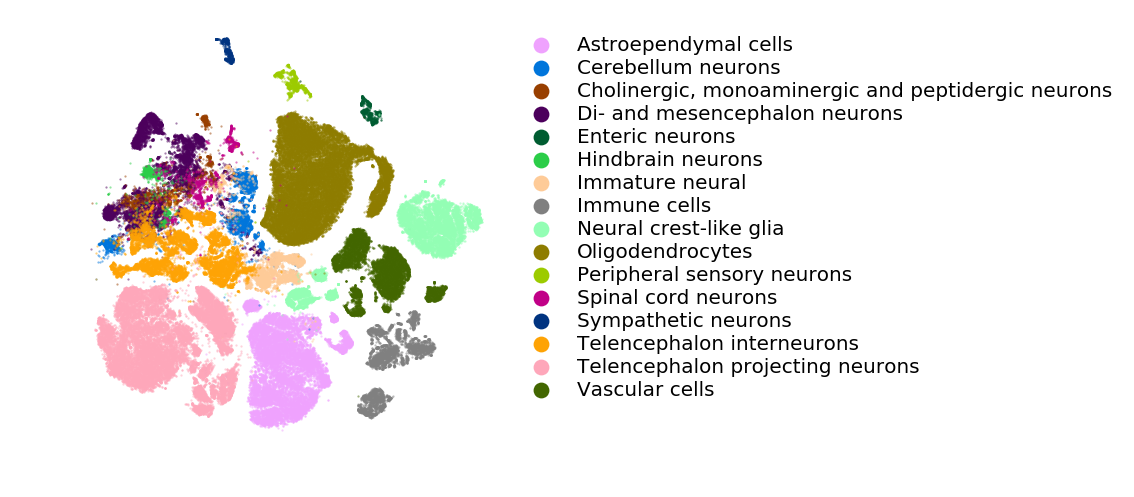

In [154]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    cmap = cm.get_cmap('tab10')
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colors75
    ix = 0
#    for taxon in ["Peripheral neurons", "Central neurons", "Astroependymal cells", "Oligodendrocytes", "Arcane glia", "Immune cells", "Vascular cells"]:
    for taxon in np.unique(ds.ca.TaxonomyRank3):
        cells = ds.ca.TaxonomyRank3 == taxon
        color = cmap((ix + 0.5)/10)
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=5,c=colors[ix,:], marker='.', label=taxon,alpha=0.5, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
    plt.savefig("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1B_Classes.png", dpi=600, transparent=True)

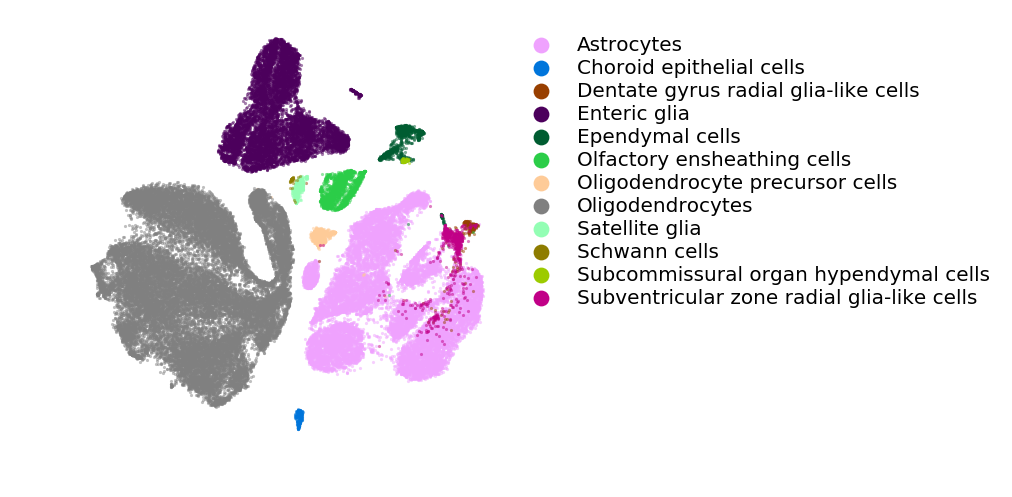

In [150]:
with loompy.connect("/Users/sten/build_20171205/L6_R1_(Glia).loom") as ds:
    cmap = cm.get_cmap('tab10')
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.unique(ds.ca.TaxonomyRank4))
    ix = 0
#    for taxon in ["Peripheral neurons", "Central neurons", "Astroependymal cells", "Oligodendrocytes", "Arcane glia", "Immune cells", "Vascular cells"]:
    for taxon in np.unique(ds.ca.TaxonomyRank4):
        cells = ds.ca.TaxonomyRank4 == taxon
        color = cmap((ix + 0.5)/10)
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=10,c=colors[ix,:], marker='.', label=taxon,alpha=0.5, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
 #   plt.savefig("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1B_Classes.png", dpi=600, transparent=True)

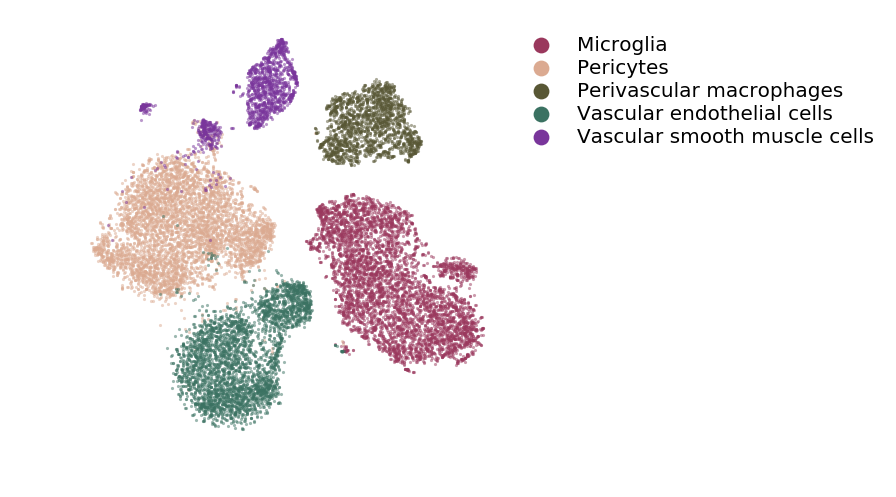

In [175]:
with loompy.connect("/Users/sten/build_20171205/L6_R1_(Blood).loom") as ds:
    cmap = cm.get_cmap('tab10')
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    colors = cg.colorize(np.unique(ds.ca.TaxonomyRank4))
    ix = 0
#    for taxon in ["Peripheral neurons", "Central neurons", "Astroependymal cells", "Oligodendrocytes", "Arcane glia", "Immune cells", "Vascular cells"]:
    for taxon in np.unique(ds.ca.TaxonomyRank4):
        cells = ds.ca.TaxonomyRank4 == taxon
        color = cmap((ix + 0.5)/10)
        plt.scatter(x=ds.ca._X[cells], y=ds.ca._Y[cells], s=10,c=colors[ix,:], marker='.', label=taxon,alpha=0.5, lw=0)
        ix += 1
        lgnd = ax.legend(fontsize=10, labelspacing=0.2, loc="upper left", bbox_to_anchor=(1, 1),frameon=False)
        for handle in lgnd.legendHandles:
            handle.set_sizes([250])
            handle.set_alpha(1)
 #   plt.savefig("/Users/sten/Dropbox (Linnarsson Group)/linnarsson group/Manuscripts/Whole brain/Figures/Figure_parts/Fig1B_Classes.png", dpi=600, transparent=True)

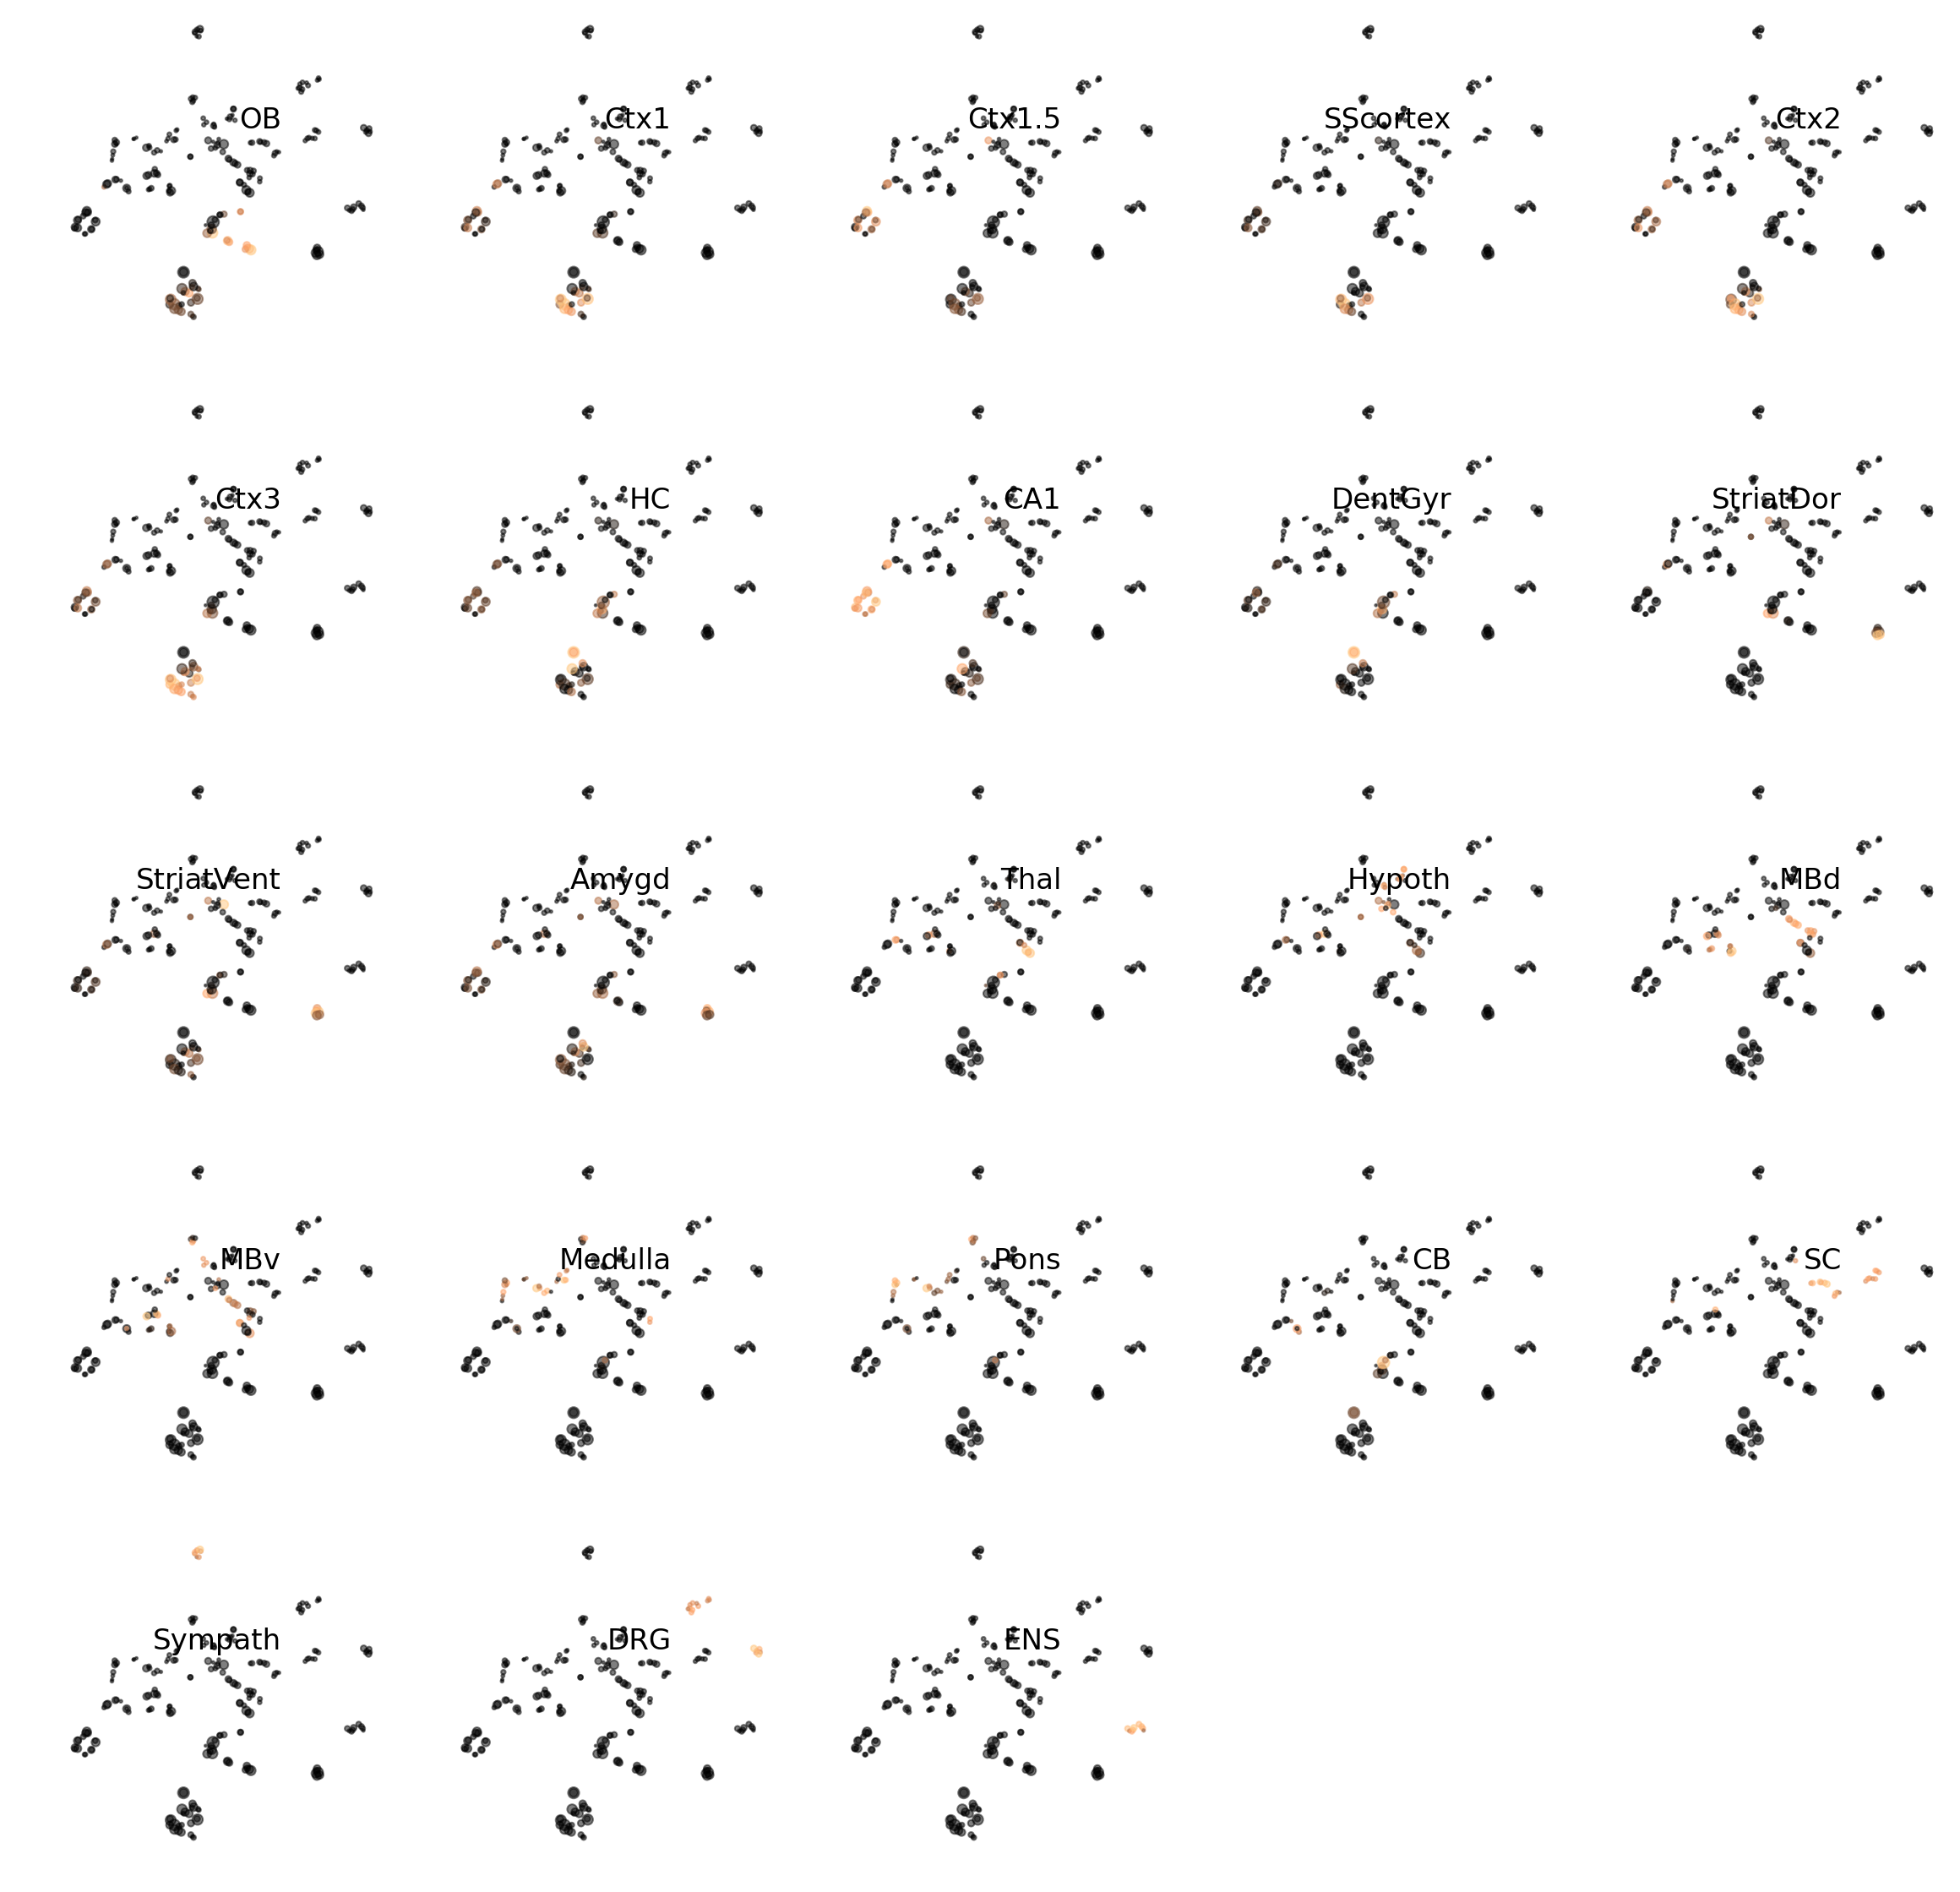

In [19]:
tissues = [
 'Tissue_OB',
 'Tissue_Ctx1',
 'Tissue_Ctx1.5',
 'Tissue_SScortex',
 'Tissue_Ctx2',
 'Tissue_Ctx3',
 'Tissue_HC',
 'Tissue_CA1',
 'Tissue_DentGyr',
 'Tissue_StriatDor',
 'Tissue_StriatVent',
 'Tissue_Amygd',
 'Tissue_Thal',
 'Tissue_Hypoth',
 'Tissue_MBd',
 'Tissue_MBv',
 'Tissue_Medulla',
 'Tissue_Pons',
 'Tissue_CB',
 'Tissue_SC',
 'Tissue_Sympath',
 'Tissue_DRG',
 'Tissue_ENS'
]
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    fig = plt.figure(figsize=(20,20))
    for ix,val in enumerate(tissues):
        ax = plt.subplot(5,5,1+ix)
        ax.axis('off')
        plt.text(18, 18, f"{val[7:]}", fontsize=17, horizontalalignment='right')
        plt.scatter(x=tsne[:,0], y=tsne[:,1],s=np.sqrt(ds.ca.NCells[neurons])*3, c=np.log(ds.col_attrs[val][neurons]+1), cmap="copper", marker='.',alpha=0.5)
    plt.savefig("Tissues.png")

In [97]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    leaforder = np.array([int(x) for x in ds.ca.LeafOrder])
    for g, gene_names in {"Tubb3": ["Tubb3"], "Foxg1": ["Foxg1"], "Emx1": ["Emx1"], "En1": ["Lhx9"], "Otx2": ["Otx2"], "Hox_1-5": ["Hoxa1", "Hoxb1", "Hoxd1", "Hoxa2", "Hoxb2", "Hoxa3", "Hoxb3", "Hoxd3", "Hoxa4", "Hoxb4", "Hoxc4", "Hoxd4", "Hoxa5", "Hoxb5", "Hoxc5"], "Hox_6-10": ["Hoxa6", "Hoxb6", "Hoxc6", "Hoxa7", "Hoxb7", "Hoxb8", "Hoxc8", "Hoxd8", "Hoxa9", "Hoxb9", "Hoxc9", "Hoxd9", "Hoxa10", "Hoxc10", "Hoxd10"], "Sox10": ["Sox10"], "Mog": ["Mog"]}.items():
        genes = np.isin(ds.ra.Gene, gene_names)
        data = ds[genes, :]
        result = np.zeros((10, 8))
        legend_x = []
        legend_y = []
        for i, (c, cell_type_names) in enumerate({"Neurons": ds.ca.ClusterName[leaforder >= 90], "Astrocytes": ["ACTE1", "ACTE2", "ACOB", "ACNT1", "ACNT2"], "OPC": ["OPC"], "COP": ["COP1", "COP2"], "NFOL": ["NFOL1", "NFOL2"], "MFOL": ["MFOL1", "MFOL2"], "MOL": ["MOL1", "MOL2", "MOL3"]}.items()):
            legend_x.append(c)
            for j, (t, tissues) in enumerate({"Olfactory": ["OB"], "Cortex": ["Ctx1", "Ctx1.5", "Ctx2", "Ctx3"], "Hippocampus": ["CA1", "DentGyr", "HC"], "Striatum": ["StratDor", "StriatVent"], "Amygdala": ["Amygd"], "Hypothalamus": ["Hypoth"], "Thalamus": ["Thal"], "Midbrain": ["MBd", "MBv"], "Hindbrain": ["Pons", "Medulla", "CB"], "Spinal cord": ["SC"]}.items()):
                legend_y.append(t)
                cols = np.isin(ds.ca.ClusterName, cell_type_names) & np.isin(ds.ca.Tissue, tissues)
                if cols.sum() > 0:
                    result[j, i] = np.count_nonzero(data[:, cols]) / (data.shape[0] * cols.sum())
        plt.figure(figsize=(4/4,10/3))
        ax = plt.subplot(111)
        ax.axis("off")
        for i, c in enumerate(legend_x):
            plt.scatter(np.zeros(10) + i/2, 10 - np.arange(10), s=result[:, i]*250, c="black",lw=0)
        plt.xticks(np.arange(8)/2, legend_x, rotation="vertical")
        plt.yticks(10-np.arange(10), legend_y)
        #plt.title(g)
#        break
        plt.savefig(f"Oligo_patterning_{g}.pdf", bbox_inches='tight')
        plt.close()

In [92]:
plt.figure(figsize=(4/4,10/3))
ax = plt.subplot(111)
ax.axis("off")
plt.scatter(np.zeros(10), 10 - np.arange(10), s=np.arange(10)*25, c="black",lw=0)
plt.xticks(np.arange(8)/2, legend_x, rotation="vertical")
plt.yticks(10-np.arange(10), legend_y)
plt.savefig(f"Oligo_patterning_scale.pdf", bbox_inches='tight')
plt.close()

In [8]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom-luigi-tmp-9802578914") as ds:
    labels = ds.ca.Clusters
    _, zero_strt_sort_noholes_lbls = np.unique(labels, return_inverse=True)
    n_groups = np.unique(labels).shape[0]
    m = np.empty((ds.shape[0], n_groups))
    for (_, selection, view) in ds.scan(axis=0):
        vals_aggr = npg.aggregate(zero_strt_sort_noholes_lbls, view[:, :], func="mean", axis=1, fill_value=0)
        m[selection, :] = vals_aggr


In [110]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    #print(np.unique(ds.ca.Tissue))
    celltypes = ["VECV", "VECC", "PER2", "PER1", "VSMCA", "PER3", "VECA", "VLMC1", "VLMC2", "ABC", "ENVLMC", "SATG1", "SATG2", "SCHW", "OPC", "OEC"]
    celltypes.reverse()
    result = np.zeros((13, 16))
    legend_x = []
    legend_y = []
    for i, c in enumerate(celltypes):
        legend_x.append(c)
        for j, (t, tissues) in enumerate({"Olfactory": ["OB"], "Cortex": ["Ctx1", "Ctx1.5", "Ctx2", "Ctx3"], "Hippocampus": ["CA1", "DentGyr", "HC"], "Striatum": ["StratDor", "StriatVent"], "Amygdala": ["Amygd"], "Hypothalamus": ["Hypoth"], "Thalamus": ["Thal"], "Midbrain": ["MBd", "MBv"], "Hindbrain": ["Pons", "Medulla", "CB"], "Spinal cord": ["SC"], "Enteric": ["ENS"], "Sympathetic": ["Sympath"], "Sensory": ["DRG"]}.items()):
            legend_y.append(t)
            cols = (ds.ca.ClusterName == c) & np.isin(ds.ca.Tissue, tissues)
            n_cells_in_tissue = np.isin(ds.ca.Tissue, tissues).sum()
            result[j, i] = cols.sum() / n_cells_in_tissue
    plt.figure(figsize=(3,3))
    ax = plt.subplot(111)
    #ax.axis("off")
    for i, c in enumerate(legend_x):
        plt.scatter(np.zeros(13) + i/2, 16 - np.arange(13), s=result[:, i]*3000,edgecolors="black", c="pink",alpha=0.9,lw=0.5)
    plt.xticks(np.arange(16)/2, legend_x, rotation="vertical")
    plt.yticks(16-np.arange(13), legend_y)
    #plt.title(g)
#        break
    plt.savefig(f"Vascular_distribution.pdf", bbox_inches='tight')
    plt.close()

In [111]:
result

array([[  1.43991492e-01,   3.89932648e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.05600851e-03,   8.79120879e-03,   1.06345268e-03,
          1.41793690e-04,   2.48138958e-03,   2.97766749e-03,
          9.42928040e-03,   1.41793690e-03,   2.83587380e-03,
          8.57851826e-03],
       [  0.00000000e+00,   2.87034130e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.52132574e-04,   1.25577432e-03,   2.01820873e-03,
          6.72736243e-04,   1.21092524e-03,   2.01820873e-03,
          2.96003947e-02,   2.60124680e-03,   4.44005920e-03,
          1.30062340e-02],
       [  0.00000000e+00,   6.94329641e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.25932661e-03,   1.32253265e-03,
          2.20422108e-04,   5.51055271e-04,   2.86548741e-03,
          1.36661707e-02,   8.26582906e-04,   1.92869345e-03,
          7.4943

In [17]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom-luigi-tmp-3655899071") as ds:
    print(ds.ca.OriginalClusters.max())

24


In [69]:
df = pd.read_csv("/Users/sten/datasets_for_comparison/Sympathetic.tab",sep="\t", header=[0,1,2], index_col=0)
df.columns.names = df.columns[0]
df = df.iloc[:, 1:]
ca = {df.columns.names[ix]: np.asarray(df.columns.tolist())[:, ix] for ix in range(len(df.columns.names))}
ra = {"Gene": df.index.values}
m = df.values
loompy.create("Sympathetic.loom", m, ra, ca, file_attrs={
    "title": "Sympathetic nervous system", 
    "description": "Sympathetic nervous system by Furlan et al. 2016",
    "doi": "doi:10.1038/nn.4376",
    "url": "https://www.nature.com/articles/nn.4376"
})

In [79]:
df = pd.read_csv("/Users/sten/datasets_for_comparison/Cortex_expression_mRNA_17-Aug-2014.txt",
                 sep="\t", 
                 header=[0,1,2,3,4,5,6,7,8,9], 
                 index_col=0
                )
df.columns.names = df.columns[0]
df = df.iloc[:, 1:]
ca = {df.columns.names[ix]: np.asarray(df.columns.tolist())[:, ix] for ix in range(len(df.columns.names))}
ra = {"Gene": df.index.values}
m = df.values
df
loompy.create("Cortex.loom", m, ra, ca, file_attrs={
    "title": "Cortex and hippocampus", 
    "description": "Cortex and hippocampus by Zeisel et al. 2015",
    "doi": "doi:10.1126/science.aaa1934",
    "url": "http://science.sciencemag.org/content/early/2015/02/18/science.aaa1934.full"
})

In [101]:
df = pd.read_csv("/Users/sten/datasets_for_comparison/Munoz-Manchado_et_al_molecules.tab",
                 sep="\t", 
                 header=[0,1,2,3,4,5,6], 
                 index_col=0
                )
df.columns.names = df.columns[0]
df = df.iloc[:, 1:]
ca = {df.columns.names[ix]: np.asarray(df.columns.tolist())[:, ix] for ix in range(len(df.columns.names))}
ra = {"Gene": df.index.values}
m = df.values
df
loompy.create("Striatum.loom", m, ra, ca, file_attrs={
    "title": "Striatum", 
    "description": "Striatum by Munoz-Manchado et al."
})
df

cell_id       1772092298_A12 1772092299_H08 1772092295_F07 1772078108_E09  \
cluster                  Sst            Sst            Sst            Sst   
strain           Lhx6icreRFP    Lhx6icreRFP    Lhx6icreRFP    Lhx6icreRFP   
GFP                        0              0              0              0   
RFP                        1              1              1              1   
age                       27             27             25             22   
sex                       -1             -1             -1             -1   
gene_symbol                                                                 
Xkr4                       0              0              0              1   
Sox17                      0              0              0              0   
Mrpl15                     1              0              2              2   
Lypla1                     1              2              1              3   
Tcea1                      4              0              5              0   
Rgs20                      0              0              0              0   
Atp6v1h                    6              1              8              4   
Oprk1                      0              0              0              0   
Npbwr1                     0              0              0              0   
Rb1cc1                     1              1              8              0   
St18                       1              0              0              0   
Pcmtd1                     0              1              1              0   
Sntg1                      0              0              0              1   
Rrs1                       0              0              0              0   
3110035E14Rik              0              0              0              0   
Vcpip1                     7              0              1              1   
Sgk3                       0              0              0              0   
Snhg6                      0              0              4              3   
Snord87                    0              0              0              0   
Cops5                      2              2              7              3   
Cspp1                      4              0              0              3   
Arfgef1                    0              0              0              2   
Prex2                      0              0              0              1   
A830018L16Rik              0              1              0              0   
Slco5a1                    0              0              0              0   
Ncoa2                      0              0              0              0   
Tram1                      0              0              0              1   
Lactb2                     0              0              0              0   
Eya1                       0              0              0              0   
Kcnb2                      0              0              0              0   
...                      ...            ...            ...            ...   
Ace2                       0              0              0              0   
Pir                        0              0              0              0   
Piga                       0              0              0              0   
Asb11                      0              0              0              0   
Mospd2                     0              0              0              0   
Fancb                      0              0              0              0   
Glra2                      1              0              0              0   
Gemin8                     0              0              0              0   
Gpm6b                      3              0              1              0   
Ofd1                       0              0              0              0   
Trappc2                    5              2              0              0   
Rab9                       2              0              3              2   
Tceanc                     0              0              0              0

In [100]:
df = pd.read_csv("/Users/sten/datasets_for_comparison/Dorsal_horn_molecule_counts.tab",
                 sep="\t", 
                 header=[0,1,2,3,4,5,6], 
                 index_col=0
                )
df.columns.names = df.columns[0]
df = df.iloc[:, 1:]
ca = {df.columns.names[ix]: np.asarray(df.columns.tolist())[:, ix] for ix in range(len(df.columns.names))}
ra = {"Gene": df.index.values}
m = df.values
loompy.create("Dorsal_horn.loom", m, ra, ca, file_attrs={
    "title": "Dorsal horn", 
    "description": "Dorsal horn by Häring et al."
})
df

cellid            1772099315_F07 1772123028_E07 1772099315_A01 1772099093_B11  \
age(days)                     22             25             22             20   
sex(female=1)                  1              0              1              0   
total mol                  10814           6950           7595          17736   
cluster name        Glut_Cck_Maf   Glut_Cck_Maf   Glut_Cck_Maf   Glut_Cck_Maf   
standard_names             Glut1          Glut1          Glut1          Glut1   
strain                    C57bl6    vGlut2-eGFP         C57bl6         C57bl6   
gene_symbol                                                                     
Xkr4                           0              0              0              0   
Rp1                            0              0              0              0   
Sox17                          0              0              0              0   
Mrpl15                         1              1              0              0   
Lypla1                         0              0              0              0   
Tcea1                          0              2              0              0   
Rgs20                          0              0              0              0   
Atp6v1h                        1              0              0              0   
Oprk1                          0              0              0              0   
Npbwr1                         0              0              0              0   
Rb1cc1                         0              1              2              3   
Fam150a                        0              0              0              0   
St18                           0              0              0              0   
Pcmtd1                         3              0              0              3   
Sntg1                          0              0              0              0   
Rrs1                           0              0              0              0   
Adhfe1                         0              0              0              0   
2610203C22Rik                  0              0              0              0   
3110035E14Rik                  0              0              0              0   
Mybl1                          0              0              0              0   
Vcpip1                         0              1              0              0   
1700034P13Rik                  0              0              0              0   
Sgk3                           0              0              0              1   
Mcmdc2                         0              0              0              0   
Snhg6                          0              0              0              0   
Snord87                        0              0              0              0   
Ppp1r42                        0              0              0              0   
Cops5                          0              1              0              0   
Cspp1                          0              0              2              0   
Arfgef1                        0              0              0              0   
...                          ...            ...            ...            ...   
Gm20823_loc6                   0              0              0              0   
Gm20738_loc2                   0              0              0              0   
Gm20736_loc4                   0              0              0              0   
Gm20865_loc2                   0              0              0              0   
LOC100040786_loc3              0              0              0              0   
Ssty2_loc3                     0              0              0              0   
Gm20806_loc1                   0              0              0              0   
Gm20823_loc7                   0              0              0              0   
Gm20736_loc5                   0              0              0              0   
Gm20823_loc8                   0              0              0              0   
Gm20736_loc6                   

In [107]:
df = pd.read_csv("/Users/sten/datasets_for_comparison/Marques_et_al_mol_counts.tab.txt",
                 sep="\t", 
                 header=0, 
                 index_col=0
                )
#df = df.iloc[:, 1:]
ca = {"cell_id": df.columns.values}
ra = {"Gene": df.index.values}
m = df.values
loompy.create("Oligos.loom", m, ra, ca, file_attrs={
    "title": "Oligodendrocytes", 
    "description": "Oligodendrocytes by Marques et al. 2016",
    "doi": "doi:10.1126/science.aaf6463",
    "url": "http://science.sciencemag.org/content/352/6291/1326"
})
df

C1-1771017-032-E11  C1-1862091-035-C04  C1-1771017-030-G04  \
cellid                                                                      
Xkr4                            0                   0                   0   
Rp1                             0                   0                   0   
Sox17                           0                   0                   0   
Mrpl15                          0                   1                   0   
Lypla1                          0                   0                   0   
Rgs20                           0                   0                   0   
Oprk1                           0                   0                   0   
Npbwr1                          0                   0                   0   
St18                            0                   0                   0   
Sntg1                           0                   0                   0   
Rrs1                            0                   0                   0   
Adhfe1                          0                   0                   0   
2610203C22Rik                   0                   0                   0   
3110035E14Rik                   1                   4                   1   
Mybl1                           0                   0                   0   
Vcpip1                          0                   0                   0   
1700034P13Rik                   0                   0                   0   
Sgk3                            0                   0                   0   
Mcmdc2                          0                   0                   0   
Snhg6                           0                   0                   0   
Snord87                         0                   0                   0   
Ppp1r42                         0                   0                   0   
Cspp1                           0                   0                   0   
Arfgef1                         1                   0                   0   
Cpa6                            0                   0                   0   
Prex2                           0                   0                   0   
A830018L16Rik                   0                   0                   0   
Sulf1                           0                   0                   0   
Slco5a1                         0                   0                   0   
Prdm14                          0                   0                   0   
...                           ...                 ...                 ...   
Asb11                           0                   0                   0   
Mospd2                          0                   0                   0   
Fancb                           0                   0                   0   
Glra2                           0                   0                   0   
Gemin8                          0                   0                   0   
Ofd1                            0                   0                   0   
Trappc2                         0                   0                   0   
Rab9                            0                   0                   0   
Tceanc                          0                   0                   0   
Egfl6                           0                   0                   0   
Gm8817                          0                   0                   0   
Tlr7                            0                   0                   0   
Prps2                           0                   0                   0   
Frmpd4                          0                   0                   0   
Msl3                            0                   0                   1   
Arhgap6                         0                   0                   0   
Hccs                            0                   0                   0   
Mid1                            0                   0                   0   
G530011O06Rik                   0                   0                   0   
Vamp7      

In [139]:
df = pd.read_csv("/Users/sten/Dropbox (Linnarsson Group)/Linnarsson Group Archive/projects/Perivascular_macrophages/cortex.tab",
                 sep="\t", 
                 header=[0,1,2,3,4,5,6,7,8,9], 
                 index_col=[0,1,2],
                 skipinitialspace=True
                )
df.columns.names = ["Tissue", "Group", "Total_mRNA", "Well", "Sex", "Age", "Diameter", "CellID", "Class", "Subclass"]
ca = {df.columns.names[ix]: np.asarray(df.columns.tolist())[:, ix] for ix in range(len(df.columns.names))}
ra = {df.index.names[ix]: np.asarray(df.index.tolist())[:, ix] for ix in range(len(df.index.names))} 
m = df.values
loompy.create("Cortex.loom", m, ra, ca, file_attrs={
    "title": "Cortex and hippocampus", 
    "description": "Cortex and hippocampus by Zeisel et al. 2015",
    "doi": "doi:10.1126/science.aaa1934",
    "url": "http://science.sciencemag.org/content/early/2015/02/18/science.aaa1934.full"
})

In [156]:
d = "/Users/sten/Dropbox (Linnarsson Group)/Linnarsson group/Manuscripts/Whole brain/Datasets_comparisons"
genes = []
for f in os.listdir(d):
    with loompy.connect(os.path.join(d, f)) as ds:
        genes.append(np.array([x.strip("'") for x in ds.ra.Gene]))
from functools import reduce
allgenes = reduce(np.union1d, genes)

In [171]:
n_genes = len(allgenes)
for f in os.listdir(d):
    with loompy.connect(os.path.join(d, f)) as ds:
        for (_,_,view) in ds.scan(axis=1):
            genes = [x.strip("'") for x in ds.ra.Gene]
            indices = overlap(genes, allgenes)
            m = np.zeros((n_genes, view.shape[1]))
            m[indices, :] = view[:, :]
            loompy.create_append(os.path.join(d, f[:-5] + "_allgenes.loom"), m, {"Gene": allgenes}, view.ca)

In [ ]:
LabelEncoder().fit()

In [2]:
d = "/Users/sten/Dropbox (Linnarsson Group)/Linnarsson group/Manuscripts/Whole brain/Datasets_comparisons"

for f in os.listdir(d):
    if not f.endswith("allgenes.loom"):
        continue
    if f.startswith("Oligos"):
        continue
    with loompy.connect(os.path.join(d, f)) as ds:
        print(f)
        cg.Aggregator().aggregate(ds, os.path.join(d, f[:-5] + ".agg.loom"))

2017-12-25 23:07:36,818 INFO:Aggregating clusters by mean 


Dorsal_horn_allgenes.loom


2017-12-25 23:07:37,094 INFO:Trinarizing 
2017-12-25 23:07:37,096 INFO:n_labels 30 
2017-12-25 23:07:37,342 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2017-12-25 23:07:37,343 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2017-12-25 23:07:53,738 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:07:53,740 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:07:53,819 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:07:53,821 INFO:Computing enrichment null distribution 
/Users/sten/Code/cytograph/cytograph/marker_selection.py:86: RuntimeWarning: divide by zero encountered in true_divide
  enrichment = (f_nnz + 0.1) / (f_nnz_other + 0.1) * (means + 0.01) / (means_other + 0.01)
2017-12-25 23:07:56,234 INFO:Computing enrichment statistic 
2017-12-25 23:07:58,591 INFO:Computing enrichment FDR-corrected P values 
2017-12-25 23

Sympathetic_allgenes.loom


2017-12-25 23:08:21,337 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:08:21,338 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:08:21,380 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:08:21,382 INFO:Computing enrichment null distribution 
2017-12-25 23:08:21,921 INFO:Computing enrichment statistic 
2017-12-25 23:08:22,460 INFO:Computing enrichment FDR-corrected P values 
2017-12-25 23:08:22,543 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:08:22,545 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 60 
2017-12-25 23:08:22,602 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:08:22,603 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 61 
2017-12-25 23:08:22,633 IN

dentate_gyrus_C1_allgenes.loom


2017-12-25 23:08:30,361 INFO:Trinarizing 
2017-12-25 23:08:30,363 INFO:n_labels 17 
2017-12-25 23:08:30,388 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2017-12-25 23:08:30,389 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2017-12-25 23:08:43,026 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:08:43,028 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:08:43,096 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:08:43,097 INFO:Computing enrichment null distribution 
2017-12-25 23:08:46,757 INFO:Computing enrichment statistic 
2017-12-25 23:08:50,040 INFO:Computing enrichment FDR-corrected P values 
2017-12-25 23:08:50,204 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:08:50,205 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py,

dentate_gyrus_10X_V1_allgenes.loom


2017-12-25 23:09:09,656 INFO:Trinarizing 
2017-12-25 23:09:09,658 INFO:n_labels 22 
2017-12-25 23:09:09,705 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2017-12-25 23:09:09,707 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2017-12-25 23:09:31,990 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:09:31,992 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:09:32,059 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:09:32,061 INFO:Computing enrichment null distribution 
2017-12-25 23:09:42,176 INFO:Computing enrichment statistic 
2017-12-25 23:09:51,977 INFO:Computing enrichment FDR-corrected P values 
2017-12-25 23:09:52,348 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:09:52,350 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py,

Striatum_allgenes.loom


2017-12-25 23:10:28,057 INFO:Trinarizing 
2017-12-25 23:10:28,059 INFO:n_labels 15 
2017-12-25 23:10:28,074 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2017-12-25 23:10:28,075 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2017-12-25 23:10:38,220 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:10:38,222 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:10:38,270 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:10:38,272 INFO:Computing enrichment null distribution 
2017-12-25 23:10:39,812 INFO:Computing enrichment statistic 
2017-12-25 23:10:41,295 INFO:Computing enrichment FDR-corrected P values 
2017-12-25 23:10:41,406 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:10:41,408 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py,

Cortex_allgenes.loom


/Users/sten/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
2017-12-25 23:10:53,708 INFO:Trinarizing 
2017-12-25 23:10:53,710 INFO:n_labels 9 
2017-12-25 23:10:53,727 WARNING:╭── 'batch_scan' is deprecated. Use 'scan' instead 
2017-12-25 23:10:53,729 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/trinarizer.py, line 56 
2017-12-25 23:11:03,971 WARNING:╭── 'set_layer' is deprecated. Use 'ds.layer.Name = matrix' or 'ds.layer['Name'] = matrix' instead 
2017-12-25 23:11:03,973 WARNING:╰──> at /Users/sten/Code/cytograph/cytograph/aggregator.py, line 56 
2017-12-25 23:11:04,032 INFO:Computing cluster gene enrichment scores 
2017-12-25 23:11:04,034 INFO:Computing enrichment null distribution 
2017-12-25 23:11:09,124 INFO:Computing enrichment statistic 
2017-12-25 23:11:14,265 INFO:Computing enrichment FDR-corre

In [163]:
def overlap(a, b):
    # return the indices in a that overlap with b, also returns 
    # the corresponding index in b only works if both a and b are unique! 
    # This is not very efficient but it works
    bool_a = np.in1d(a,b)
    ind_a = np.arange(len(a))
    ind_a = ind_a[bool_a]

    ind_b = np.array([np.argwhere(b == a[x]) for x in ind_a]).flatten()
    return ind_b

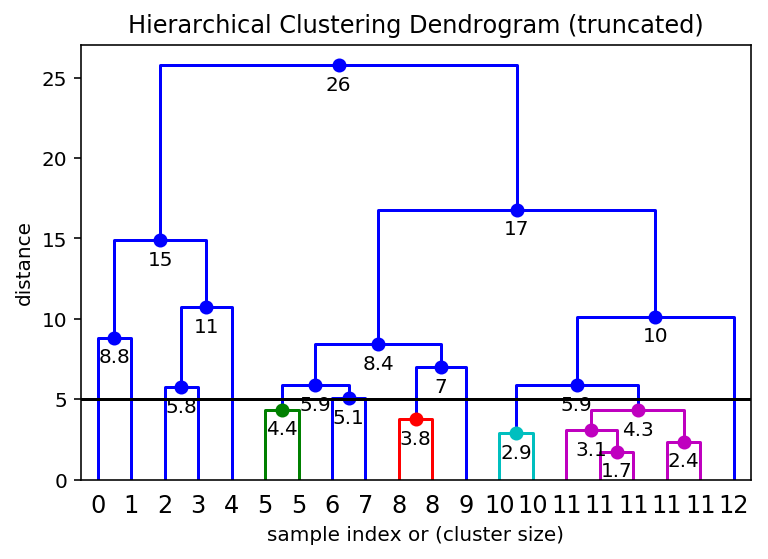

In [148]:

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.2g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

fancy_dendrogram(optimal_Z, max_d = 5, labels=clusters-1)
None

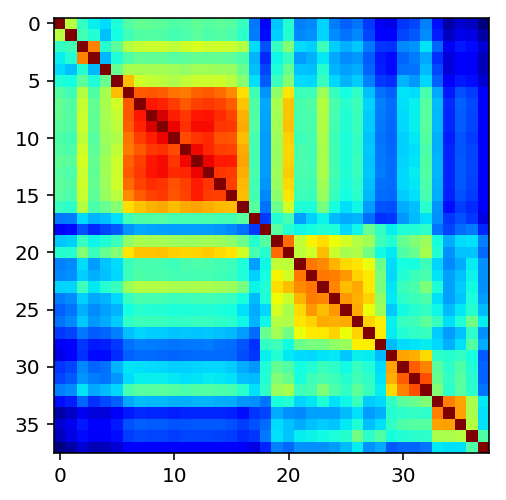

In [3]:
data = np.log(dsout[:,:] + 1)[ds.row_attrs["_Selected"] == 1, :].T
D = pdist(data, 'euclidean')
Z = hc.linkage(D, 'ward')
optimal_Z = optimal_leaf_ordering(Z, D)
ordering = hc.leaves_list(optimal_Z)
plt.imshow(squareform(D)[ordering, :][:, ordering], cmap="jet_r")

In [7]:
with lo

In [8]:
a

'20180124T091633.176815Z'

In [9]:
b

'20180124T091633.176869Z'

In [11]:
b > a

True

In [108]:
# Patch a loom file with the most recent cluster annotations
celltypes_summary_file = os.path.join("/Users/sten/build_20171205/curated_L4", "celltypes_summary_leaforder16-Dec-2017.xlsx")
celltypes_summary = pd.read_excel(celltypes_summary_file)
celltypes_dict = {celltypes_summary.columns.values[i]: celltypes_summary.values[:, i] for i in range(celltypes_summary.shape[1])}
patch_keys = ["LeafOrder", "Probable_location", "Region", "Developmental_compartment", "Description", "Location_based_on", "Neurotransmitter", "Comment"]
for key in patch_keys:
    

In [74]:
f = "/Users/sten/build_20171205/L1_DRG.loom"
with loompy.connect(f) as ds:
    totals = ds.ra._Total
    valids = (ds.ra._Selected == 1)
    print(valids.sum())
    print(totals[valids].sum()/totals[~valids].sum())

496
0.0213386898177


In [124]:
np.array([3,2,1,1,1,1])[:np.where(np.array([3,2,1,1,1,1]) == 1)[0].min()]

array([3, 2])

MOL3 ['Klk6' 'Nkx2-9'] [9.2747431043807467, 0.65440778799350996]
MOL2 ['Hapln2' 'Dock5'] [2.5329137948256917, 0.24972530216761563]
MFOL1 ['Ccp110' 'Snx33'] [2.0971769815418022, 0.27985884907709013]
MOL1 ['Opalin' 'Ninj2'] [6.0199655765920825, 0.47309236947791167]
MFOL2 ['2210011C24Rik' 'Wfdc18' 'Tmem141'] [0.8981366459627329, 0.76977225672877847, 8.9925465838509311]
NFOL1 ['Cnksr3' 'H2-Ab1'] [2.7723325062034738, 0.97146401985111663]
NFOL2 ['Tmem2' 'Gm26834'] [6.0386740331491708, 0.36464088397790057]
COP2 ['Tnr' 'Rinl'] [5.4527559055118111, 0.35826771653543305]
COP1 ['Neu4' 'Brca1'] [1.4229765013054829, 0.58355091383812008]
CHOR ['Ttr' 'Folr1'] [885.24890829694323, 6.1462882096069871]
EPMB ['Tnnt3' 'Cfap126'] [1.4782608695652173, 0.92753623188405798]
HYPEN ['Spp2' 'Sspo'] [5.5495495495495497, 5.6396396396396398]
EPSC ['1500015O10Rik' 'Slc26a3'] [7.7826086956521738, 1.2246376811594204]
EPEN ['Ccdc153' 'Krt15'] [8.0594315245478043, 1.8669250645994833]
ACMB ['Myoc' 'Gfap'] [2.4053426248548

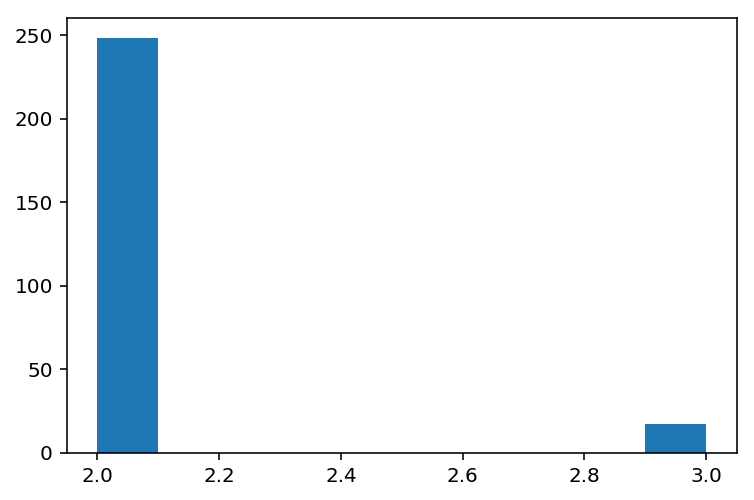

In [4]:
f = "/Users/sten/build_20171205/L5_All.agg.loom"
with loompy.connect(f) as ds:
    clusters = ds.ca.ClusterName
    markers = np.array([x.split(" ") for x in ds.ca.MarkerGenes])
    selectivity = np.array([[int(x) for x in x[1:-1].split(" ") if x != ""] for x in ds.ca.MarkerSelectivity])
    all_markers = []
    n_markers = []
    for ix in range(265):
        sel = markers[ix, :][:np.where(selectivity[ix, :]==1)[0].min()+1]
        n_markers.append(sel.shape[0])
        exp = [ds[ds.ra.Gene == x, ix][0] for x in sel]
        all_markers = all_markers + list(sel)
        print(clusters[ix], sel, exp)
    print(np.unique(all_markers).shape)
    plt.hist(n_markers)

In [5]:
np.bincount(n_markers)

array([  0,   0, 248,  17])

In [55]:
f = "/Users/sten/build_20171205/L1_DRG.loom"
with loompy.connect(f) as ds:
    data = ds[:, :][ds.ra._Valid == 1, :]
    classes = ds.ca.Class
    genes = ds.ra.Gene[ds.ra._Valid == 1]
    #print(ds.ca.CellID[ds.ca.Class == "Oligos"])

In [56]:
def div0(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0  # -inf inf NaN
    return c

In [57]:
data2 = div0(data.T, np.sum(data, axis=1)) * 5000
data2 = np.log(data2 + 1)
data2 = data2.T - np.mean(data2, axis=1)
data2 = div0(data2, np.std(data2, axis=0)).T

In [58]:
from sklearn.decomposition import PCA
pca = PCA(1000)
transformed = pca.fit_transform(data2)

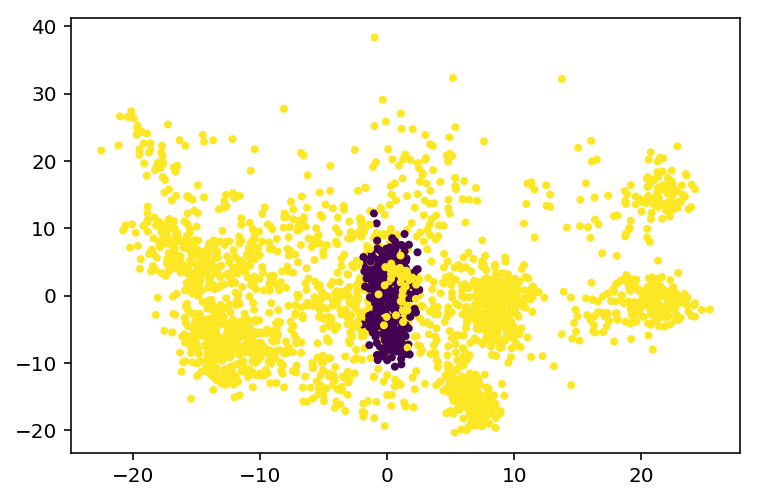

In [59]:
plt.scatter(transformed[:, 3], transformed[:, 4], marker='.', c=classes!="PeripheralGlia")

In [60]:
from sklearn.mixture import BayesianGaussianMixture as BGM
import cytograph as cg

In [88]:
labels = BGM(n_components=75, weight_concentration_prior=0.00000000001).fit(transformed).predict(transformed)

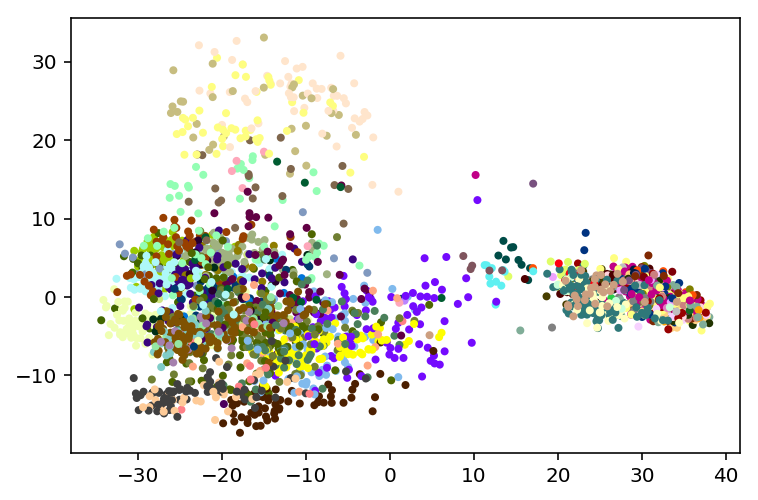

In [89]:
plt.scatter(transformed[:, 0], transformed[:, 5], marker='.', c=cg.colorize(labels))

In [90]:
labels.max() + 1

75

In [91]:
bins = np.bincount(labels)
bins[bins>10].shape
#bins

(62,)

### Computational complexity of Variational Gaussian Mixtures
According to [this paper](https://www.researchgate.net/publication/6307266_Unsupervised_Learning_of_Gaussian_Mixtures_Based_on_Variational_Component_Splitting) the computational complexity is 

$$
O(N J d^2 + J d^3)
$$

where N is the number of samples, J is the number of gaussian components, and d is the number of features.

In other words, it is linear in the number of cells and clusters, but cubic in the number of genes (or PCA components).


In [ ]:
fname = "/Users/sten/build_20171205/L5_All.loom"

with loompy.connect(fname) as ds:
    n_labels = np.unique(ds.ca.ClusterNames).shape[0]
    data = ds[:n_labels*10, :]

    logging.info("Normalization")
    vals = vals / (self.totals[cells] + 1) * normalizer().level
    # Log transform
    vals = np.log(vals + 1)
    # Subtract mean per gene
    vals = vals - self.mu[:, None]

    logging.info("PCA projection")
    pca = cg.PCAProjection(genes, max_n_components=50)
    transformed = pca.fit_transform(ds, normalizer)

    le = LabelEncoder().fit(ds.ca.ClusterNames)
    labels = le.transform(ds.ca.ClusterNames)
    
    train_X, test_X, train_Y, test_Y = train_test_split(transformed, labels, test_size=0.5)
    classifier = SVC(probability=True)
    classifier.fit(train_X, train_Y)
    print(classification_report(test_Y, classifier.predict(test_X), target_names=le.classes_))
    p = classifier.predict(transformed)

In [1]:
import loompy
import cytograph as cg
import logging

In [7]:
f = "/Users/sten/build_20171205/L1_DRG.loom"
with loompy.connect(f) as ds:
    logging.info("Clustering on the manifold")
    clusterer = cg.VbgmmClustering()
    labels = clusterer.fit_predict(ds)
    ds.ca.Clusters = labels
    logging.info(f"Found {labels.max() + 1} clusters")


2018-03-06 10:39:34,183 INFO: Clustering on the manifold
2018-03-06 10:39:34,185 INFO: VBGMM on all 27998 cells
2018-03-06 10:39:34,188 INFO: Using 12527 of 27998 genes
2018-03-06 10:39:34,190 INFO: Normalizing
2018-03-06 10:39:39,700 INFO: PCA projection to 1000 components
/Users/sten/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:271: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/sten/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2018-03-06 10:40:20,221 INFO: Finding up to 100 clusters by VBGMM, using resolution=100
2018-03-06 10:40:33,157 INFO: Found 100 clusters
2018-03-06 10:40:33,171 INFO: Found 100 clusters


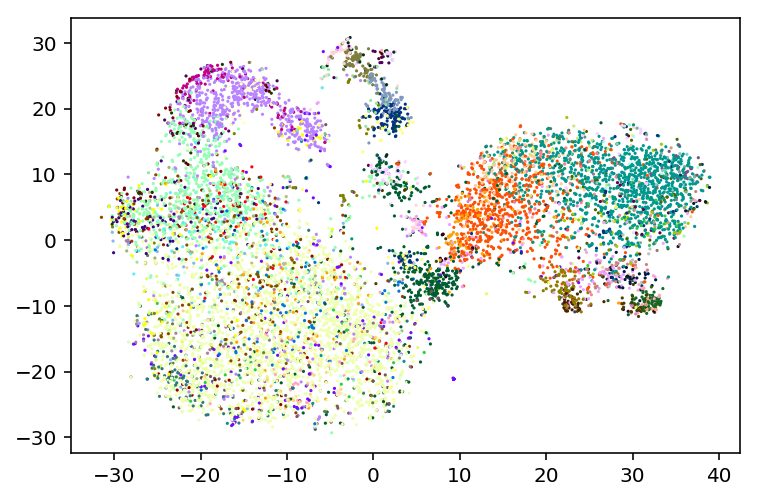

In [6]:
with loompy.connect(f) as ds:
    plt.scatter(ds.ca._X, ds.ca._Y, c=cg.colorize(labels), marker='.', s=10, lw=0)

['Astrocytes' 'Ependymal' 'Immune' 'Neurons' 'Oligos' 'PeripheralGlia'
 'Vascular']


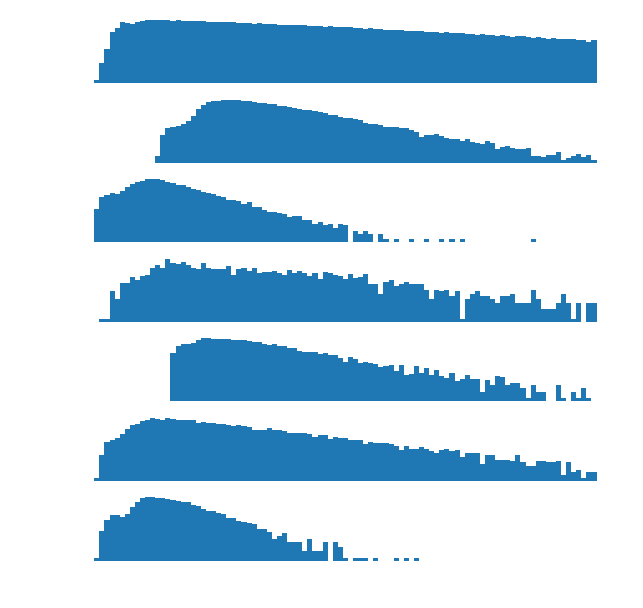

In [144]:
with loompy.connect("/Users/sten/build_20171205/L5_All.loom") as ds:
    print(np.unique(ds.ca.Class))
    plt.figure(figsize=(5,5))
    plt.subplot(711).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Neurons"], bins=100, range=(0,10000),log=True)
    plt.subplot(712).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Oligos"], bins=100, range=(0,10000),log=True)
    plt.subplot(713).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Astrocytes"], bins=100, range=(0,10000),log=True)
    plt.subplot(714).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Ependymal"], bins=100, range=(0,10000),log=True)
    plt.subplot(715).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="PeripheralGlia"], bins=100, range=(0,10000),log=True)
    plt.subplot(716).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Vascular"], bins=100, range=(0,10000),log=True)
    plt.subplot(717).axis("off")
    plt.hist(ds.ca._Total[ds.ca.Class=="Immune"], bins=100, range=(0,10000),log=True)